In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
dataset = pd.read_csv("C:\\Users\Maurice\\Documents\\QML\\CIC-IDS2017-MLCSV\\MachineLearningCVE\\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")


# Remove leading/trailing spaces from column names
dataset.columns = dataset.columns.str.strip()
# Replace infinities with NaN
dataset.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill missing values with the mode (most frequent value) for categorical columns
dataset['Label'] = dataset['Label'].fillna(dataset['Label'].mode()[0])

# Encode labels using LabelEncoder
label_encoder = LabelEncoder()
dataset['Label'] = label_encoder.fit_transform(dataset['Label'])

# Verify that there are no missing values
print(dataset.isnull().sum())  # Should print 0 for all columns

Destination Port               0
Flow Duration                  0
Total Fwd Packets              0
Total Backward Packets         0
Total Length of Fwd Packets    0
                              ..
Idle Mean                      0
Idle Std                       0
Idle Max                       0
Idle Min                       0
Label                          0
Length: 79, dtype: int64


In [3]:
# Define sample size
n_samples = 500

# Select only numeric features
df_numeric = dataset.select_dtypes(include=['number'])

# Ensure there are at least 64 features
if df_numeric.shape[1] < 64:
    raise ValueError("Dataset has fewer than 64 numeric features. Consider feature engineering or PCA.")

# Randomly sample 200 rows while maintaining class balance
df_sampled = dataset.groupby('Label', group_keys=False).apply(lambda x: x.sample(min(len(x), n_samples // dataset['Label'].nunique()), random_state=42))

# Drop non-numeric columns (if any)
df_sampled = df_sampled.select_dtypes(include=['number']).reset_index(drop=True)

C:\Users\Maurice\AppData\Local\Temp\ipykernel_8980\2294693954.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = dataset.groupby('Label', group_keys=False).apply(lambda x: x.sample(min(len(x), n_samples // dataset['Label'].nunique()), random_state=42))


In [4]:
# Select the features (numeric columns) and labels
X = df_sampled.drop(columns=['Label'])

from sklearn.preprocessing import MinMaxScaler

X= pd.DataFrame(X, columns=X.columns)

# Apply MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Encode the labels as integers
y = df_sampled['Label'].factorize()[0]  # Converts the string labels to integer labels


# Check the shape of the data
print(X.shape, y.shape)

(500, 78) (500,)


In [5]:
from sklearn.decomposition import PCA

# Apply PCA if the dataset has more than 64 features
if X.shape[1] > 32:
    pca = PCA(n_components=32)
    X = pca.fit_transform(X)
    print(f"Reduced to {X.shape[1]} features using PCA")

# Otherwise, use the data as is
else:
    print(f"Dataset already has {X.shape[1]} features")


Reduced to 32 features using PCA


Training original model...

Training Progress:
Epoch | Train Loss | Train Acc | Val Loss | Val Acc | Test Loss | Test Acc
---------------------------------------------------------------------------
    0 | 0.2090 | 0.8271 | 0.0488 | 0.9535 | 0.0512 | 0.9513
    1 | 0.1639 | 0.8592 | 0.0501 | 0.9523 | 0.0518 | 0.9508
    2 | 0.1278 | 0.8867 | 0.0474 | 0.9548 | 0.0490 | 0.9533
    3 | 0.1027 | 0.9069 | 0.0464 | 0.9557 | 0.0464 | 0.9557
    4 | 0.0854 | 0.9213 | 0.0486 | 0.9537 | 0.0468 | 0.9553
    5 | 0.0746 | 0.9306 | 0.0505 | 0.9519 | 0.0477 | 0.9544
    6 | 0.0647 | 0.9392 | 0.0509 | 0.9516 | 0.0481 | 0.9541
    7 | 0.0598 | 0.9436 | 0.0508 | 0.9516 | 0.0484 | 0.9538
    8 | 0.0546 | 0.9483 | 0.0506 | 0.9518 | 0.0487 | 0.9536
    9 | 0.0527 | 0.9499 | 0.0502 | 0.9522 | 0.0489 | 0.9534
   10 | 0.0513 | 0.9512 | 0.0501 | 0.9523 | 0.0492 | 0.9531
   11 | 0.0508 | 0.9517 | 0.0499 | 0.9525 | 0.0500 | 0.9523
   12 | 0.0507 | 0.9518 | 0.0501 | 0.9523 | 0.0509 | 0.9516
   13 | 0.0499 | 0.952

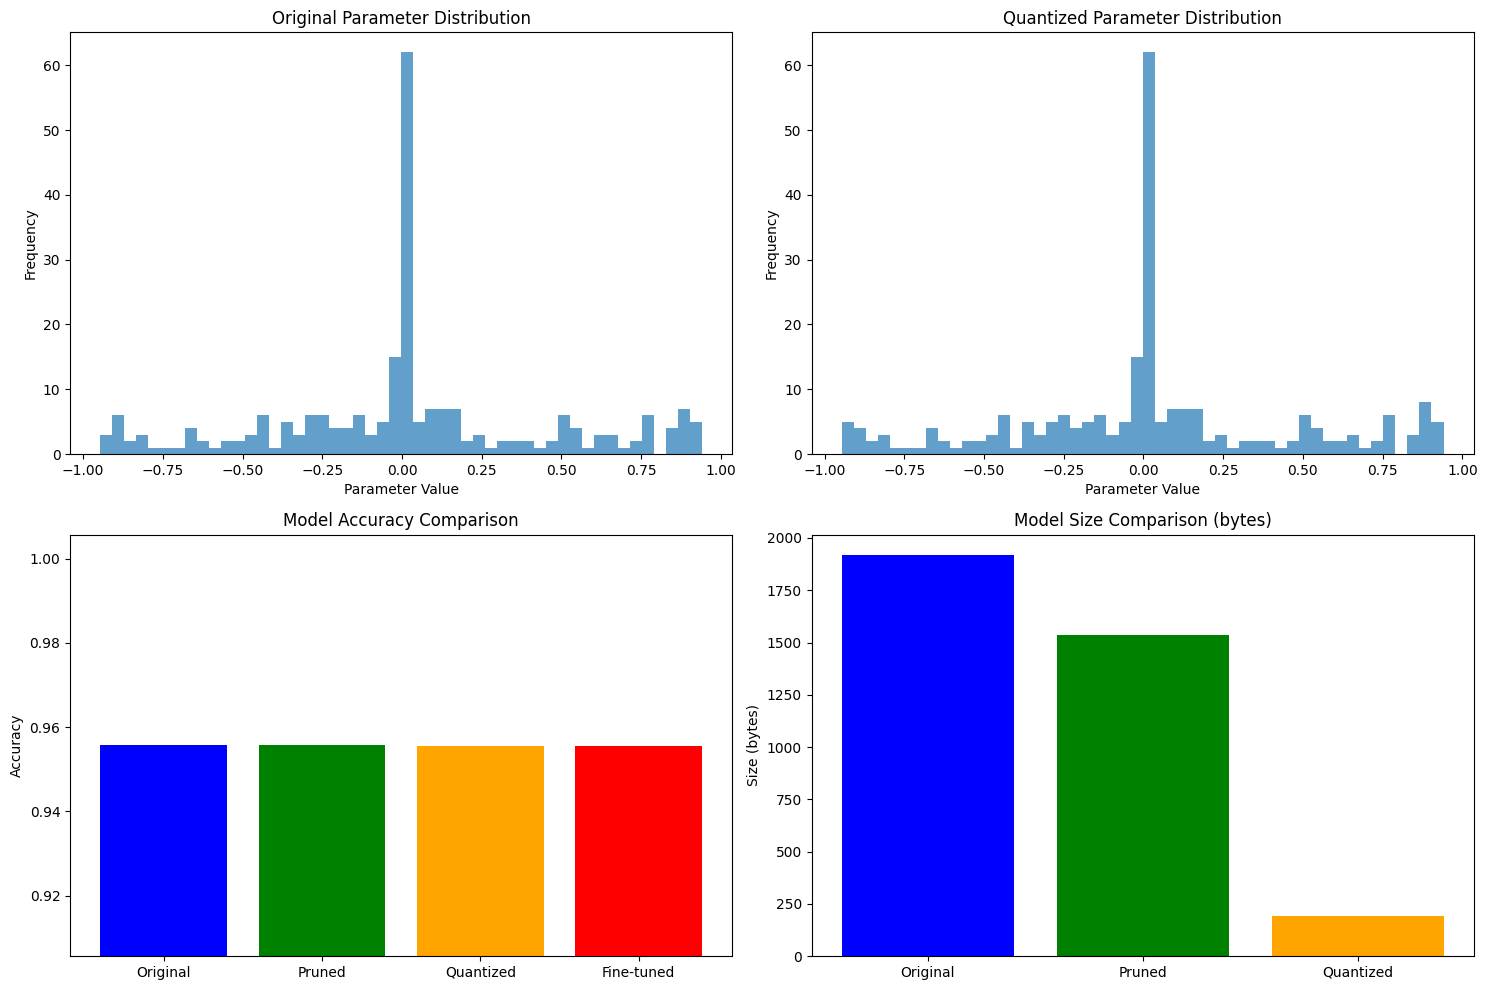

In [6]:
import pennylane as qml
import numpy as np
import torch
import random
from torch.optim import Adam
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import matplotlib.pyplot as plt

def set_seeds(seed=42):
    """Set seeds for reproducibility"""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

class QuantumAutoencoder:
    def __init__(self, n_qubits, latent_qubits, depth=4, params=None):
        self.n_qubits = n_qubits
        self.latent_qubits = latent_qubits
        self.depth = depth
        self.dev = qml.device("default.qubit", wires=n_qubits)
        
        self.n_params = self._calculate_params()
        if params is not None:
            self.params = params
        else:
            self.params = self._initialize_parameters()
        
        self.encoder = qml.QNode(self._encoder_circuit, self.dev, interface="torch")
        self.decoder = qml.QNode(self._decoder_circuit, self.dev, interface="torch")
        
        # Pruning mask (1 = keep, 0 = prune)
        self.pruning_mask = np.ones_like(self.params)
    
    def _calculate_params(self):
        """Calculate total number of parameters"""
        params_per_qubit = 6
        params_per_layer = self.n_qubits * params_per_qubit
        total_layers = 2 * self.depth
        return params_per_layer * total_layers
    
    def _initialize_parameters(self):
        """Improved parameter initialization"""
        params = np.zeros(self.n_params)
        # Xavier/Glorot initialization scaled to [0, 2π]
        scale = np.sqrt(2.0 / (self.n_qubits + self.latent_qubits)) * np.pi
        for i in range(self.n_params):
            params[i] = np.random.uniform(-scale, scale)
        return params

    def _encoder_circuit(self, data, params):
        """Enhanced encoder circuit with proper padding for 78 features"""
        # AmplitudeEmbedding handles the padding to 2^7 = 128 dimensions
        qml.AmplitudeEmbedding(data, wires=range(self.n_qubits), normalize=True, pad_with=0.0)
        
        param_idx = 0
        for d in range(self.depth):
            # More rotations per qubit
            for i in range(self.n_qubits):
                qml.Rot(params[param_idx], params[param_idx + 1], 
                       params[param_idx + 2], wires=i)
                qml.RX(params[param_idx + 3], wires=i)
                qml.RY(params[param_idx + 4], wires=i)
                qml.RZ(params[param_idx + 5], wires=i)
                param_idx += 6
            
            # Enhanced entanglement pattern
            for i in range(self.n_qubits - 1):
                qml.CRZ(params[param_idx % self.n_params], wires=[i, i + 1])
                qml.CNOT(wires=[i, i + 1])
            
            if self.n_qubits > 2:
                for i in range(0, self.n_qubits - 2, 2):
                    qml.CRX(params[(param_idx + 1) % self.n_params], wires=[i, i + 2])
                    qml.CNOT(wires=[i, i + 2])
        
        return qml.state()
    
    def _decoder_circuit(self, latent_state, params):
        """Enhanced decoder circuit"""
        qml.QubitStateVector(latent_state, wires=range(self.latent_qubits))
            
        # Better initialization of non-latent qubits
        for i in range(self.latent_qubits, self.n_qubits):
            qml.Hadamard(wires=i)
            qml.RY(np.pi/4, wires=i)
            qml.RZ(np.pi/4, wires=i)
            
        param_idx = self.n_params // 2
        for d in range(self.depth):
            for i in range(self.n_qubits):
                qml.Rot(params[param_idx], params[param_idx + 1], 
                       params[param_idx + 2], wires=i)
                qml.RX(params[param_idx + 3], wires=i)
                qml.RY(params[param_idx + 4], wires=i)
                qml.RZ(params[param_idx + 5], wires=i)
                param_idx += 6
                
            for i in range(self.n_qubits - 1):
                qml.CRZ(params[param_idx % self.n_params], wires=[i, i + 1])
                qml.CNOT(wires=[i, i + 1])
                
            if self.n_qubits > 2:
                for i in range(0, self.n_qubits - 2, 2):
                    qml.CRX(params[(param_idx + 1) % self.n_params], wires=[i, i + 2])
                    qml.CNOT(wires=[i, i + 2])
            
        return qml.state()
        
    def get_latent_state(self, encoded_state):
        """Improved latent state extraction with proper Hermitian handling"""
        if torch.is_tensor(encoded_state):
            encoded_state = encoded_state.detach().numpy()
        
        # Ensure we're working with complex numbers
        encoded_state = encoded_state.astype(complex)
        
        # Create density matrix
        state_matrix = np.outer(encoded_state, np.conjugate(encoded_state))
        
        # Extract reduced density matrix for latent space
        dim = 2**self.latent_qubits
        reduced_matrix = state_matrix[:dim, :dim]
        
        # Ensure matrix is Hermitian before eigendecomposition
        reduced_matrix = (reduced_matrix + reduced_matrix.conj().T) / 2
        
        # Perform eigendecomposition
        eigenvals, eigenvecs = np.linalg.eigh(reduced_matrix)
        
        # Use top eigenvectors with proper normalization
        top_k = 2
        top_indices = np.argsort(eigenvals)[-top_k:]
        weights = eigenvals[top_indices]
        # Normalize weights to sum to 1
        weights = weights / np.sum(weights)
        
        # Combine eigenvectors
        latent_state = np.zeros(dim, dtype=complex)
        for w, i in zip(weights, top_indices):
            latent_state += np.sqrt(w) * eigenvecs[:, i]
            
        # Ensure proper normalization
        latent_state = latent_state / np.linalg.norm(latent_state)
        return latent_state
        
    def forward(self, x):
        """Forward pass with proper tensor type handling"""
        # Convert input to numpy array if it's a tensor
        if torch.is_tensor(x):
            x_np = x.detach().numpy()
        else:
            x_np = x
            
        # Process through encoder
        encoded = self.encoder(x_np, self.params)
        
        # Get latent representation
        latent = self.get_latent_state(encoded)
        
        # Process through decoder
        decoded = self.decoder(latent, self.params)
        
        # Return result in the same format as the input
        if torch.is_tensor(x):
            # Convert to PyTorch tensor preserving gradients
            if isinstance(decoded, np.ndarray):
                decoded_tensor = torch.tensor(decoded, dtype=torch.complex128)
            else:
                decoded_tensor = decoded
            return decoded_tensor
        else:
            return decoded
    
    def apply_pruning(self, threshold_percentile=20):
        """
        Prune parameters with absolute values below a threshold percentile
        Returns the percentage of parameters pruned
        """
        abs_params = np.abs(self.params)
        threshold = np.percentile(abs_params, threshold_percentile)
        self.pruning_mask = np.where(abs_params > threshold, 1, 0)
        pruned_count = np.sum(self.pruning_mask == 0)
        return (pruned_count / len(self.params)) * 100
    
    def apply_quantization(self, bits=8):
        """
        Quantize parameters to specified bit precision
        Returns the original and quantized parameters for comparison
        """
        original_params = self.params.copy()
        
        # Find min and max for scaling
        p_min, p_max = np.min(self.params), np.max(self.params)
        
        # Scale to [0, 2^bits - 1]
        scale = (2**bits - 1) / (p_max - p_min)
        
        # Quantize
        quantized_int = np.round((self.params - p_min) * scale)
        
        # Scale back to original range
        self.params = (quantized_int / scale) + p_min
        
        # Apply pruning mask to ensure quantized pruned values stay at zero
        self.params = self.params * self.pruning_mask
        
        return original_params, self.params

def preprocess_data(X):
    """Enhanced data preprocessing specifically for 78 features mapped to 7 qubits (128 dimensions)"""
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Normalize each sample to have unit norm
    X_normalized = X_scaled / np.sqrt(np.sum(X_scaled**2, axis=1))[:, np.newaxis]
    
    # For amplitude encoding with 7 qubits (128 dimensions), padding will be handled by PennyLane
    # but we need to ensure our data is properly prepared
    return X_normalized

def evaluate_model(model, X_test):
    """Evaluate model on test data and return accuracy"""
    losses = []
    with torch.no_grad():
        for x in X_test:
            decoded = model.forward(x)
            decoded = np.real(decoded) if not torch.is_tensor(decoded) else decoded.real.numpy()
            loss = np.mean((decoded[:len(x)] - x)**2)
            losses.append(loss)
    
    test_loss = np.mean(losses)
    test_accuracy = 1 / (1 + test_loss)
    return test_loss, test_accuracy

def train_model(X, n_epochs=100, batch_size=4, learning_rate=0.002, seed=42):
    """Enhanced training process for quantum autoencoder"""
    set_seeds(seed)
    
    # Use the provided X dataset
    # Split data into train, validation, and test sets
    X_train, X_temp = train_test_split(X, test_size=0.3, random_state=seed)
    X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=seed)  # 15%/15% val/test split
    
    # Preprocess each dataset
    X_train = preprocess_data(X_train)
    X_val = preprocess_data(X_val)
    X_test = preprocess_data(X_test)
    
    # For 78 features, we need 7 qubits (2^6 = 64 < 78 < 2^7 = 128)
    n_qubits = 5
    latent_qubits = 3  # Reduced dimensionality
    
    model = QuantumAutoencoder(n_qubits=n_qubits, latent_qubits=latent_qubits)
    
    params = torch.tensor(model.params, requires_grad=True)
    optimizer = Adam([params], lr=learning_rate)
    
    best_accuracy = 0.0
    best_params = None
    patience = 10
    patience_counter = 0
    
    metrics = {'train_losses': [], 'train_accuracies': [], 
              'val_losses': [], 'val_accuracies': [], 'test_losses':[], 'test_accuracies': []}
    
    print("\nTraining Progress:")
    print("Epoch | Train Loss | Train Acc | Val Loss | Val Acc | Test Loss | Test Acc")
    print("-" * 75)
    
    for epoch in range(n_epochs):
        model.params = params.detach().numpy()
        epoch_loss = 0
        n_batches = max(1, len(X_train) // batch_size)
        
        for _ in range(n_batches):
            optimizer.zero_grad()
            batch_idx = np.random.choice(len(X_train), min(batch_size, len(X_train)))
            batch_data = X_train[batch_idx]
            
            # Initialize batch loss properly for accumulation
            batch_loss = 0.0
            
            for x in batch_data:
                # Convert input to tensor
                x_tensor = torch.tensor(x, dtype=torch.float64)
                
                # Forward pass
                decoded = model.forward(x)
                
                # Ensure decoded is a tensor with proper type
                if not torch.is_tensor(decoded):
                    decoded = torch.tensor(np.real(decoded), dtype=torch.float64, requires_grad=True)
                elif decoded.dtype != torch.float64:
                    decoded = decoded.real.to(torch.float64)
                
                # Calculate individual sample loss
                # Only compare against original dimensions
                reconstruction_loss = torch.mean((decoded[:len(x_tensor)] - x_tensor)**2)
                
                # Accumulate loss (without requiring grad)
                batch_loss += reconstruction_loss.item()
            
            # Calculate average reconstruction loss for the batch
            avg_recon_loss = batch_loss / len(batch_data)
            
            # Add L2 regularization directly to the final loss calculation
            final_loss = torch.tensor(avg_recon_loss, requires_grad=True) + 0.001 * torch.sum(params**2)
            
            # Backward pass on the properly constructed loss
            final_loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_([params], max_norm=1.0)
            
            # Optimizer step
            optimizer.step()
            
            # Record loss for this batch
            epoch_loss += final_loss.item()
        
        train_loss = epoch_loss / n_batches
        train_accuracy = 1 / (1 + train_loss)
        
        # Validation
        val_losses = []
        with torch.no_grad():
            for x in X_val:
                decoded = model.forward(x)
                decoded = np.real(decoded) if not torch.is_tensor(decoded) else decoded.real.numpy()
                val_loss = np.mean((decoded[:len(x)] - x)**2)
                val_losses.append(val_loss)
        
        # Evaluate on test set
        test_losses = []
        with torch.no_grad():
            for x in X_test:
                decoded = model.forward(x)
                decoded = np.real(decoded) if not torch.is_tensor(decoded) else decoded.real.numpy()
                test_loss = np.mean((decoded[:len(x)] - x)**2)
                test_losses.append(test_loss)

        test_loss = np.mean(test_losses)
        test_accuracy = 1 / (1 + test_loss)
        val_loss = np.mean(val_losses)
        val_accuracy = 1 / (1 + val_loss)

        metrics['test_losses'].append(test_loss)
        metrics['test_accuracies'].append(test_accuracy)
        metrics['train_losses'].append(train_loss)
        metrics['train_accuracies'].append(train_accuracy)
        metrics['val_losses'].append(val_loss)
        metrics['val_accuracies'].append(val_accuracy)
        
        print(f"{epoch:5d} | {train_loss:.4f} | {train_accuracy:.4f} | {val_loss:.4f} | {val_accuracy:.4f} | {test_loss:.4f} | {test_accuracy:.4f}")
        
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params = params.detach().clone()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("\nEarly stopping triggered!")
            break
        
        if val_accuracy >= 0.998 and train_accuracy >= 0.998:
            print("\nTarget accuracy achieved!")
            break
    
    model.params = best_params.numpy()
    return model, best_accuracy, metrics, X_test

def compare_models(X, seed=42):
    """Train and compare original, pruned, and quantized models"""
    set_seeds(seed)
    
    # # Create synthetic dataset if needed
    # if X is None:
    #     X, _ = make_classification(n_samples=200, n_features=78, random_state=seed)
    
    # Train original model
    print("Training original model...")
    original_model, _, _, X_test = train_model(X, n_epochs=50, seed=seed)
    
    # Evaluate original model
    print("\nEvaluating original model...")
    original_loss, original_accuracy = evaluate_model(original_model, X_test)
    
    # Create pruned model (clone from original)
    print("\nApplying pruning...")
    pruned_model = QuantumAutoencoder(
        n_qubits=original_model.n_qubits,
        latent_qubits=original_model.latent_qubits,
        depth=original_model.depth,
        params=original_model.params.copy()
    )
    
    # Apply pruning (prune 20% of smallest magnitude parameters)
    pruning_percentage = pruned_model.apply_pruning(threshold_percentile=20)
    print(f"Pruned {pruning_percentage:.2f}% of parameters")
    
    # Evaluate pruned model
    pruned_loss, pruned_accuracy = evaluate_model(pruned_model, X_test)
    
    # Create quantized model (clone from pruned)
    print("\nApplying quantization...")
    quantized_model = QuantumAutoencoder(
        n_qubits=pruned_model.n_qubits,
        latent_qubits=pruned_model.latent_qubits,
        depth=pruned_model.depth,
        params=pruned_model.params.copy()
    )
    quantized_model.pruning_mask = pruned_model.pruning_mask.copy()
    
    # Apply 8-bit quantization
    original_params, quantized_params = quantized_model.apply_quantization(bits=8)
    
    # Evaluate quantized model
    quantized_loss, quantized_accuracy = evaluate_model(quantized_model, X_test)
    
    # Fine-tune quantized model
    print("\nFine-tuning quantized model...")
    # Convert params to tensor for fine-tuning
    params = torch.tensor(quantized_model.params, requires_grad=True)
    optimizer = Adam([params], lr=0.0005)  # Lower learning rate for fine-tuning
    
    # Preprocess data
    X_train, _ = train_test_split(X, test_size=0.3, random_state=seed)
    X_train = preprocess_data(X_train)
    
    # Fine-tuning loop (shorter)
    for epoch in range(20):
        # Apply params to model
        quantized_model.params = params.detach().numpy()
        
        # Batch processing
        batch_idx = np.random.choice(len(X_train), min(8, len(X_train)))
        batch_data = X_train[batch_idx]
        
        # Process batch
        optimizer.zero_grad()
        
        # Track loss as a tensor with gradients
        batch_loss = torch.tensor(0.0, dtype=torch.float64, requires_grad=True)
        
        for i, x in enumerate(batch_data):
            x_tensor = torch.tensor(x, dtype=torch.float64)
            
            # Set model parameters for this forward pass
            quantized_model.params = params.detach().numpy()
            
            # Forward pass
            decoded = quantized_model.forward(x)
            
            # Ensure decoded is a tensor with proper type
            if not torch.is_tensor(decoded):
                decoded = torch.tensor(np.real(decoded), dtype=torch.float64)
            elif decoded.dtype != torch.float64:
                decoded = decoded.real.to(torch.float64)
            
            # Calculate MSE loss with gradients attached
            if i == 0:
                # For the first sample, create a loss tensor with gradients
                batch_loss = torch.mean((decoded[:len(x_tensor)] - x_tensor)**2)
            else:
                # For subsequent samples, accumulate loss
                batch_loss = batch_loss + torch.mean((decoded[:len(x_tensor)] - x_tensor)**2)
        
        # Calculate average loss
        avg_loss = batch_loss / len(batch_data)
        
        # Add L2 regularization
        final_loss = avg_loss + 0.001 * torch.sum(params**2)
        
        # Backward and optimize
        final_loss.backward()
        optimizer.step()
        
        # Re-quantize after gradient update
        quantized_model.params = params.detach().numpy()
        _, quantized_model.params = quantized_model.apply_quantization(bits=8)
        params.data = torch.tensor(quantized_model.params)
        
        # Keep pruned parameters at zero
        quantized_model.params = quantized_model.params * quantized_model.pruning_mask
        params.data = torch.tensor(quantized_model.params)
        
        if (epoch + 1) % 5 == 0:
            try:
                print(f"Fine-tuning epoch {epoch+1}, Loss: {final_loss.item():.6f}")
            except:
                print(f"Fine-tuning epoch {epoch+1}, Loss calculation failed but training continues")
    
    # Final evaluation of fine-tuned quantized model
    finetuned_loss, finetuned_accuracy = evaluate_model(quantized_model, X_test)
    
    # Calculate compression metrics
    param_count = len(original_model.params)
    original_size = param_count * 64  # 64-bit floating point (8 bytes)
    pruned_size = np.sum(pruned_model.pruning_mask) * 64  # Only non-pruned params
    quantized_size = np.sum(quantized_model.pruning_mask) * 8  # 8-bit quantized non-pruned params
    compression_ratio = original_size / quantized_size
    
    # Print results
    print("\n" + "="*50)
    print("MODEL COMPARISON RESULTS")
    print("="*50)
    print(f"Original Model Accuracy:       {original_accuracy:.6f}")
    print(f"Pruned Model Accuracy:         {pruned_accuracy:.6f}")
    print(f"Quantized Model Accuracy:      {quantized_accuracy:.6f}")
    print(f"Fine-tuned Quantized Accuracy: {finetuned_accuracy:.6f}")
    print("-"*50)
    print(f"Original Size:        {original_size/8:.1f} bytes (100.0%)")
    print(f"After Pruning:        {pruned_size/8:.1f} bytes ({pruned_size/original_size*100:.1f}%)")
    print(f"After Quantization:   {quantized_size/8:.1f} bytes ({quantized_size/original_size*100:.1f}%)")
    print(f"Compression Ratio:    {compression_ratio:.2f}x")
    print(f"Accuracy Change:      {(finetuned_accuracy-original_accuracy)/original_accuracy*100:.2f}%")
    
    # Plot parameter distribution before and after quantization
    plt.figure(figsize=(15, 10))
    
    # Original parameters histogram
    plt.subplot(2, 2, 1)
    plt.hist(original_params.flatten(), bins=50, alpha=0.7)
    plt.title("Original Parameter Distribution")
    plt.xlabel("Parameter Value")
    plt.ylabel("Frequency")
    
    # Quantized parameters histogram
    plt.subplot(2, 2, 2)
    plt.hist(quantized_params.flatten(), bins=50, alpha=0.7)
    plt.title("Quantized Parameter Distribution")
    plt.xlabel("Parameter Value")
    plt.ylabel("Frequency")
    
    # Accuracy comparison
    plt.subplot(2, 2, 3)
    models = ["Original", "Pruned", "Quantized", "Fine-tuned"]
    accuracies = [original_accuracy, pruned_accuracy, quantized_accuracy, finetuned_accuracy]
    plt.bar(models, accuracies, color=['blue', 'green', 'orange', 'red'])
    plt.ylim(min(accuracies) - 0.05, max(accuracies) + 0.05)
    plt.title("Model Accuracy Comparison")
    plt.ylabel("Accuracy")
    
    # Size comparison
    plt.subplot(2, 2, 4)
    sizes = [original_size/8, pruned_size/8, quantized_size/8]
    size_labels = ["Original", "Pruned", "Quantized"]
    plt.bar(size_labels, sizes, color=['blue', 'green', 'orange'])
    plt.title("Model Size Comparison (bytes)")
    plt.ylabel("Size (bytes)")
    
    plt.tight_layout()
    plt.savefig("quantum_model_comparison.png")
    
    return {
        "original_accuracy": original_accuracy,
        "pruned_accuracy": pruned_accuracy, 
        "quantized_accuracy": quantized_accuracy,
        "finetuned_accuracy": finetuned_accuracy,
        "compression_ratio": compression_ratio,
        "pruning_percentage": pruning_percentage
    }

# # Generate synthetic data for testing if needed
# def generate_synthetic_data(n_samples=200, n_features=78, seed=42):
#     set_seeds(seed)
#     X, _ = make_classification(n_samples=n_samples, n_features=n_features, random_state=seed)
#     return X

if __name__ == "__main__":
    # To use synthetic data, uncomment this line:
    # X = generate_synthetic_data()
    
    # For real data, make sure X is defined
    # X = ...  # Your data with approx 78 features
    
    # Compare models and get results
    results = compare_models(X)
    
    # Print summary
    print("\nSUMMARY:")
    print(f"Original model accuracy: {results['original_accuracy']:.6f}")
    print(f"Final model accuracy: {results['finetuned_accuracy']:.6f}")
    print(f"Compression ratio: {results['compression_ratio']:.2f}x")
    print(f"Accuracy impact: {(results['finetuned_accuracy']-results['original_accuracy'])/results['original_accuracy']*100:.2f}%")

Training original model...

Training Progress:
Epoch | Train Loss | Train Acc | Val Loss | Val Acc | Test Loss | Test Acc
---------------------------------------------------------------------------
    0 | 0.2090 | 0.8271 | 0.0488 | 0.9535 | 0.0512 | 0.9513
    1 | 0.1639 | 0.8592 | 0.0501 | 0.9523 | 0.0518 | 0.9508
    2 | 0.1278 | 0.8867 | 0.0474 | 0.9548 | 0.0490 | 0.9533
    3 | 0.1027 | 0.9069 | 0.0464 | 0.9557 | 0.0464 | 0.9557
    4 | 0.0854 | 0.9213 | 0.0486 | 0.9537 | 0.0468 | 0.9553
    5 | 0.0746 | 0.9306 | 0.0505 | 0.9519 | 0.0477 | 0.9544
    6 | 0.0647 | 0.9392 | 0.0509 | 0.9516 | 0.0481 | 0.9541
    7 | 0.0598 | 0.9436 | 0.0508 | 0.9516 | 0.0484 | 0.9538
    8 | 0.0546 | 0.9483 | 0.0506 | 0.9518 | 0.0487 | 0.9536
    9 | 0.0527 | 0.9499 | 0.0502 | 0.9522 | 0.0489 | 0.9534
   10 | 0.0513 | 0.9512 | 0.0501 | 0.9523 | 0.0492 | 0.9531
   11 | 0.0508 | 0.9517 | 0.0499 | 0.9525 | 0.0500 | 0.9523
   12 | 0.0507 | 0.9518 | 0.0501 | 0.9523 | 0.0509 | 0.9516
   13 | 0.0499 | 0.952

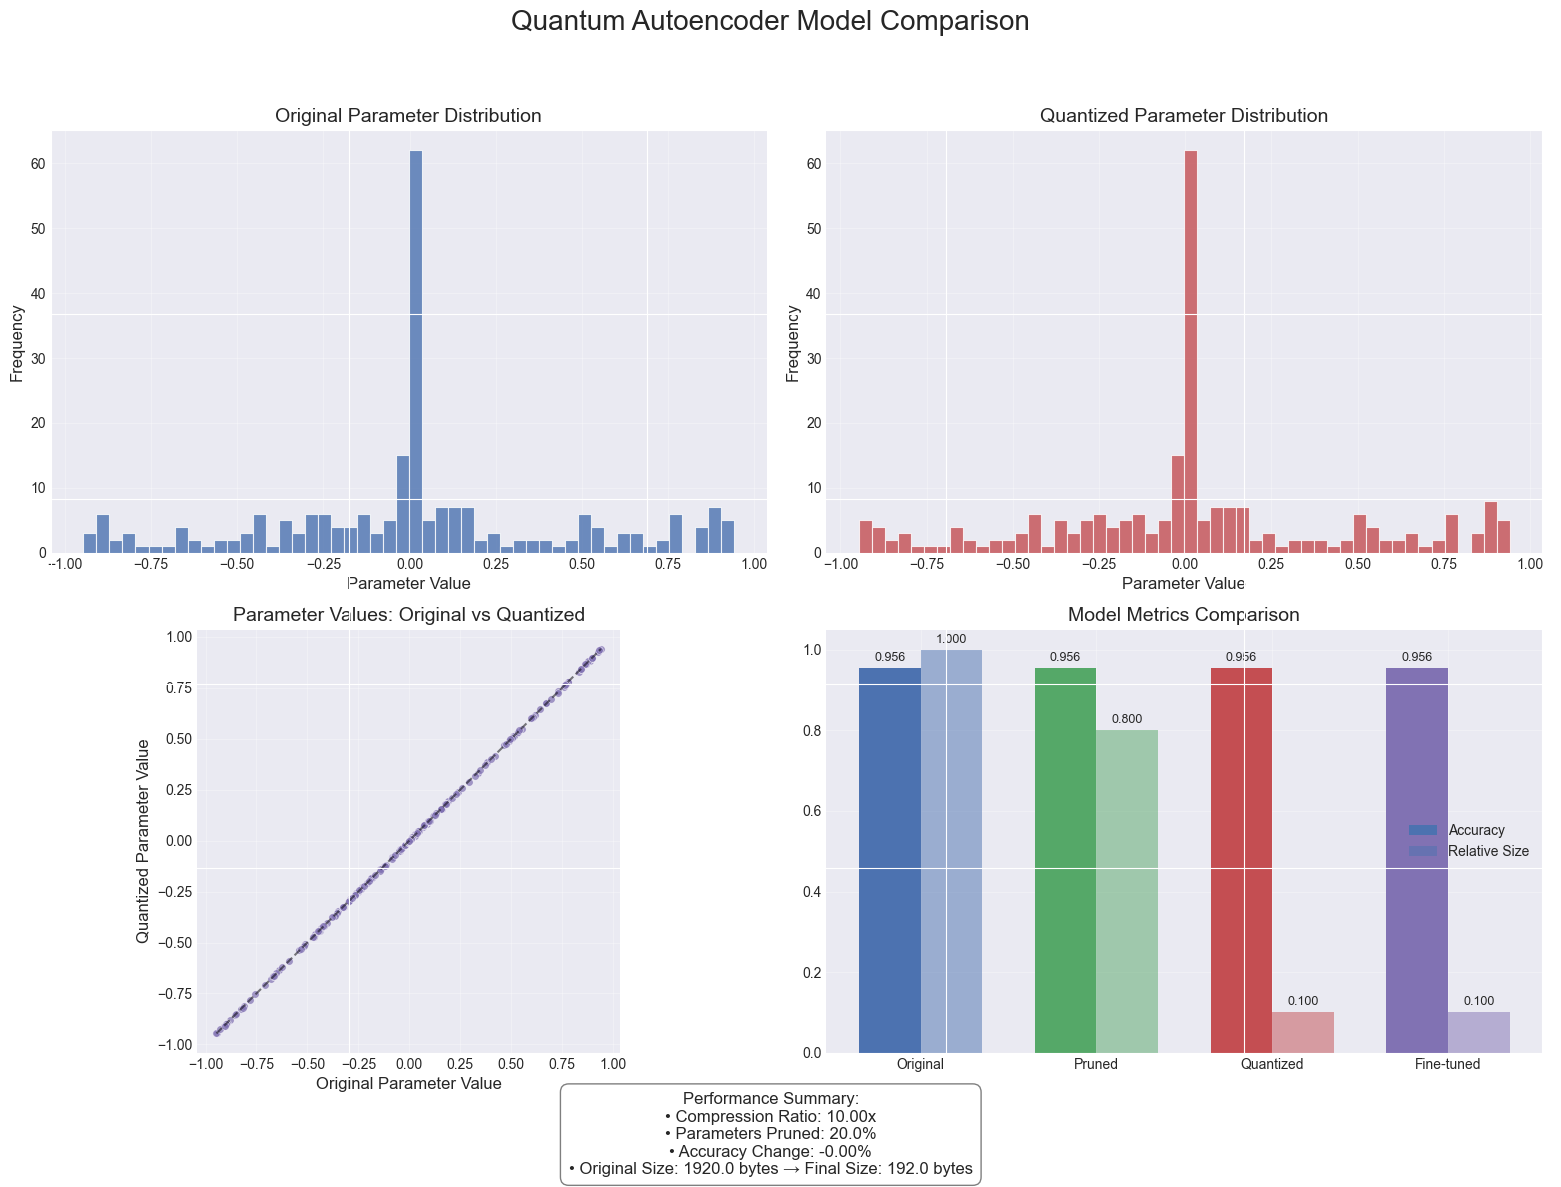

In [8]:
import pennylane as qml
import numpy as np
import torch
import random
from torch.optim import Adam
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import matplotlib.pyplot as plt

def set_seeds(seed=42):
    """Set seeds for reproducibility"""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

class QuantumAutoencoder:
    def __init__(self, n_qubits, latent_qubits, depth=4, params=None):
        self.n_qubits = n_qubits
        self.latent_qubits = latent_qubits
        self.depth = depth
        self.dev = qml.device("default.qubit", wires=n_qubits)
        
        self.n_params = self._calculate_params()
        if params is not None:
            self.params = params
        else:
            self.params = self._initialize_parameters()
        
        self.encoder = qml.QNode(self._encoder_circuit, self.dev, interface="torch")
        self.decoder = qml.QNode(self._decoder_circuit, self.dev, interface="torch")
        
        # Pruning mask (1 = keep, 0 = prune)
        self.pruning_mask = np.ones_like(self.params)
    
    def _calculate_params(self):
        """Calculate total number of parameters"""
        params_per_qubit = 6
        params_per_layer = self.n_qubits * params_per_qubit
        total_layers = 2 * self.depth
        return params_per_layer * total_layers
    
    def _initialize_parameters(self):
        """Improved parameter initialization"""
        params = np.zeros(self.n_params)
        # Xavier/Glorot initialization scaled to [0, 2π]
        scale = np.sqrt(2.0 / (self.n_qubits + self.latent_qubits)) * np.pi
        for i in range(self.n_params):
            params[i] = np.random.uniform(-scale, scale)
        return params

    def _encoder_circuit(self, data, params):
        """Enhanced encoder circuit with proper padding for 78 features"""
        # AmplitudeEmbedding handles the padding to 2^7 = 128 dimensions
        qml.AmplitudeEmbedding(data, wires=range(self.n_qubits), normalize=True, pad_with=0.0)
        
        param_idx = 0
        for d in range(self.depth):
            # More rotations per qubit
            for i in range(self.n_qubits):
                qml.Rot(params[param_idx], params[param_idx + 1], 
                       params[param_idx + 2], wires=i)
                qml.RX(params[param_idx + 3], wires=i)
                qml.RY(params[param_idx + 4], wires=i)
                qml.RZ(params[param_idx + 5], wires=i)
                param_idx += 6
            
            # Enhanced entanglement pattern
            for i in range(self.n_qubits - 1):
                qml.CRZ(params[param_idx % self.n_params], wires=[i, i + 1])
                qml.CNOT(wires=[i, i + 1])
            
            if self.n_qubits > 2:
                for i in range(0, self.n_qubits - 2, 2):
                    qml.CRX(params[(param_idx + 1) % self.n_params], wires=[i, i + 2])
                    qml.CNOT(wires=[i, i + 2])
        
        return qml.state()
    
    def _decoder_circuit(self, latent_state, params):
        """Enhanced decoder circuit"""
        qml.QubitStateVector(latent_state, wires=range(self.latent_qubits))
            
        # Better initialization of non-latent qubits
        for i in range(self.latent_qubits, self.n_qubits):
            qml.Hadamard(wires=i)
            qml.RY(np.pi/4, wires=i)
            qml.RZ(np.pi/4, wires=i)
            
        param_idx = self.n_params // 2
        for d in range(self.depth):
            for i in range(self.n_qubits):
                qml.Rot(params[param_idx], params[param_idx + 1], 
                       params[param_idx + 2], wires=i)
                qml.RX(params[param_idx + 3], wires=i)
                qml.RY(params[param_idx + 4], wires=i)
                qml.RZ(params[param_idx + 5], wires=i)
                param_idx += 6
                
            for i in range(self.n_qubits - 1):
                qml.CRZ(params[param_idx % self.n_params], wires=[i, i + 1])
                qml.CNOT(wires=[i, i + 1])
                
            if self.n_qubits > 2:
                for i in range(0, self.n_qubits - 2, 2):
                    qml.CRX(params[(param_idx + 1) % self.n_params], wires=[i, i + 2])
                    qml.CNOT(wires=[i, i + 2])
            
        return qml.state()
        
    def get_latent_state(self, encoded_state):
        """Improved latent state extraction with proper Hermitian handling"""
        if torch.is_tensor(encoded_state):
            encoded_state = encoded_state.detach().numpy()
        
        # Ensure we're working with complex numbers
        encoded_state = encoded_state.astype(complex)
        
        # Create density matrix
        state_matrix = np.outer(encoded_state, np.conjugate(encoded_state))
        
        # Extract reduced density matrix for latent space
        dim = 2**self.latent_qubits
        reduced_matrix = state_matrix[:dim, :dim]
        
        # Ensure matrix is Hermitian before eigendecomposition
        reduced_matrix = (reduced_matrix + reduced_matrix.conj().T) / 2
        
        # Perform eigendecomposition
        eigenvals, eigenvecs = np.linalg.eigh(reduced_matrix)
        
        # Use top eigenvectors with proper normalization
        top_k = 2
        top_indices = np.argsort(eigenvals)[-top_k:]
        weights = eigenvals[top_indices]
        # Normalize weights to sum to 1
        weights = weights / np.sum(weights)
        
        # Combine eigenvectors
        latent_state = np.zeros(dim, dtype=complex)
        for w, i in zip(weights, top_indices):
            latent_state += np.sqrt(w) * eigenvecs[:, i]
            
        # Ensure proper normalization
        latent_state = latent_state / np.linalg.norm(latent_state)
        return latent_state
        
    def forward(self, x):
        """Forward pass with proper tensor type handling"""
        # Convert input to numpy array if it's a tensor
        if torch.is_tensor(x):
            x_np = x.detach().numpy()
        else:
            x_np = x
            
        # Process through encoder
        encoded = self.encoder(x_np, self.params)
        
        # Get latent representation
        latent = self.get_latent_state(encoded)
        
        # Process through decoder
        decoded = self.decoder(latent, self.params)
        
        # Return result in the same format as the input
        if torch.is_tensor(x):
            # Convert to PyTorch tensor preserving gradients
            if isinstance(decoded, np.ndarray):
                decoded_tensor = torch.tensor(decoded, dtype=torch.complex128)
            else:
                decoded_tensor = decoded
            return decoded_tensor
        else:
            return decoded
    
    def apply_pruning(self, threshold_percentile=20):
        """
        Prune parameters with absolute values below a threshold percentile
        Returns the percentage of parameters pruned
        """
        abs_params = np.abs(self.params)
        threshold = np.percentile(abs_params, threshold_percentile)
        self.pruning_mask = np.where(abs_params > threshold, 1, 0)
        pruned_count = np.sum(self.pruning_mask == 0)
        return (pruned_count / len(self.params)) * 100
    
    def apply_quantization(self, bits=8):
        """
        Quantize parameters to specified bit precision
        Returns the original and quantized parameters for comparison
        """
        original_params = self.params.copy()
        
        # Find min and max for scaling
        p_min, p_max = np.min(self.params), np.max(self.params)
        
        # Scale to [0, 2^bits - 1]
        scale = (2**bits - 1) / (p_max - p_min)
        
        # Quantize
        quantized_int = np.round((self.params - p_min) * scale)
        
        # Scale back to original range
        self.params = (quantized_int / scale) + p_min
        
        # Apply pruning mask to ensure quantized pruned values stay at zero
        self.params = self.params * self.pruning_mask
        
        return original_params, self.params

def preprocess_data(X):
    """Enhanced data preprocessing specifically for 78 features mapped to 7 qubits (128 dimensions)"""
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Normalize each sample to have unit norm
    X_normalized = X_scaled / np.sqrt(np.sum(X_scaled**2, axis=1))[:, np.newaxis]
    
    # For amplitude encoding with 7 qubits (128 dimensions), padding will be handled by PennyLane
    # but we need to ensure our data is properly prepared
    return X_normalized

def evaluate_model(model, X_test):
    """Evaluate model on test data and return accuracy"""
    losses = []
    with torch.no_grad():
        for x in X_test:
            decoded = model.forward(x)
            decoded = np.real(decoded) if not torch.is_tensor(decoded) else decoded.real.numpy()
            loss = np.mean((decoded[:len(x)] - x)**2)
            losses.append(loss)
    
    test_loss = np.mean(losses)
    test_accuracy = 1 / (1 + test_loss)
    return test_loss, test_accuracy

def train_model(X, n_epochs=100, batch_size=4, learning_rate=0.002, seed=42):
    """Enhanced training process for quantum autoencoder"""
    set_seeds(seed)
    
    # Use the provided X dataset
    # Split data into train, validation, and test sets
    X_train, X_temp = train_test_split(X, test_size=0.3, random_state=seed)
    X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=seed)  # 15%/15% val/test split
    
    # Preprocess each dataset
    X_train = preprocess_data(X_train)
    X_val = preprocess_data(X_val)
    X_test = preprocess_data(X_test)
    
    # For 78 features, we need 7 qubits (2^6 = 64 < 78 < 2^7 = 128)
    n_qubits = 5
    latent_qubits = 3  # Reduced dimensionality
    
    model = QuantumAutoencoder(n_qubits=n_qubits, latent_qubits=latent_qubits)
    
    params = torch.tensor(model.params, requires_grad=True)
    optimizer = Adam([params], lr=learning_rate)
    
    best_accuracy = 0.0
    best_params = None
    patience = 10
    patience_counter = 0
    
    metrics = {'train_losses': [], 'train_accuracies': [], 
              'val_losses': [], 'val_accuracies': [], 'test_losses':[], 'test_accuracies': []}
    
    print("\nTraining Progress:")
    print("Epoch | Train Loss | Train Acc | Val Loss | Val Acc | Test Loss | Test Acc")
    print("-" * 75)
    
    for epoch in range(n_epochs):
        model.params = params.detach().numpy()
        epoch_loss = 0
        n_batches = max(1, len(X_train) // batch_size)
        
        for _ in range(n_batches):
            optimizer.zero_grad()
            batch_idx = np.random.choice(len(X_train), min(batch_size, len(X_train)))
            batch_data = X_train[batch_idx]
            
            # Initialize batch loss properly for accumulation
            batch_loss = 0.0
            
            for x in batch_data:
                # Convert input to tensor
                x_tensor = torch.tensor(x, dtype=torch.float64)
                
                # Forward pass
                decoded = model.forward(x)
                
                # Ensure decoded is a tensor with proper type
                if not torch.is_tensor(decoded):
                    decoded = torch.tensor(np.real(decoded), dtype=torch.float64, requires_grad=True)
                elif decoded.dtype != torch.float64:
                    decoded = decoded.real.to(torch.float64)
                
                # Calculate individual sample loss
                # Only compare against original dimensions
                reconstruction_loss = torch.mean((decoded[:len(x_tensor)] - x_tensor)**2)
                
                # Accumulate loss (without requiring grad)
                batch_loss += reconstruction_loss.item()
            
            # Calculate average reconstruction loss for the batch
            avg_recon_loss = batch_loss / len(batch_data)
            
            # Add L2 regularization directly to the final loss calculation
            final_loss = torch.tensor(avg_recon_loss, requires_grad=True) + 0.001 * torch.sum(params**2)
            
            # Backward pass on the properly constructed loss
            final_loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_([params], max_norm=1.0)
            
            # Optimizer step
            optimizer.step()
            
            # Record loss for this batch
            epoch_loss += final_loss.item()
        
        train_loss = epoch_loss / n_batches
        train_accuracy = 1 / (1 + train_loss)
        
        # Validation
        val_losses = []
        with torch.no_grad():
            for x in X_val:
                decoded = model.forward(x)
                decoded = np.real(decoded) if not torch.is_tensor(decoded) else decoded.real.numpy()
                val_loss = np.mean((decoded[:len(x)] - x)**2)
                val_losses.append(val_loss)
        
        # Evaluate on test set
        test_losses = []
        with torch.no_grad():
            for x in X_test:
                decoded = model.forward(x)
                decoded = np.real(decoded) if not torch.is_tensor(decoded) else decoded.real.numpy()
                test_loss = np.mean((decoded[:len(x)] - x)**2)
                test_losses.append(test_loss)

        test_loss = np.mean(test_losses)
        test_accuracy = 1 / (1 + test_loss)
        val_loss = np.mean(val_losses)
        val_accuracy = 1 / (1 + val_loss)

        metrics['test_losses'].append(test_loss)
        metrics['test_accuracies'].append(test_accuracy)
        metrics['train_losses'].append(train_loss)
        metrics['train_accuracies'].append(train_accuracy)
        metrics['val_losses'].append(val_loss)
        metrics['val_accuracies'].append(val_accuracy)
        
        print(f"{epoch:5d} | {train_loss:.4f} | {train_accuracy:.4f} | {val_loss:.4f} | {val_accuracy:.4f} | {test_loss:.4f} | {test_accuracy:.4f}")
        
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params = params.detach().clone()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("\nEarly stopping triggered!")
            break
        
        if val_accuracy >= 0.998 and train_accuracy >= 0.998:
            print("\nTarget accuracy achieved!")
            break
    
    model.params = best_params.numpy()
    return model, best_accuracy, metrics, X_test

def compare_models(X, seed=42):
    """Train and compare original, pruned, and quantized models"""
    set_seeds(seed)
    
    # # Create synthetic dataset if needed
    # if X is None:
    #     X, _ = make_classification(n_samples=200, n_features=78, random_state=seed)
    
    # Train original model
    print("Training original model...")
    original_model, _, _, X_test = train_model(X, n_epochs=50, seed=seed)
    
    # Evaluate original model
    print("\nEvaluating original model...")
    original_loss, original_accuracy = evaluate_model(original_model, X_test)
    
    # Create pruned model (clone from original)
    print("\nApplying pruning...")
    pruned_model = QuantumAutoencoder(
        n_qubits=original_model.n_qubits,
        latent_qubits=original_model.latent_qubits,
        depth=original_model.depth,
        params=original_model.params.copy()
    )
    
    # Apply pruning (prune 20% of smallest magnitude parameters)
    pruning_percentage = pruned_model.apply_pruning(threshold_percentile=20)
    print(f"Pruned {pruning_percentage:.2f}% of parameters")
    
    # Evaluate pruned model
    pruned_loss, pruned_accuracy = evaluate_model(pruned_model, X_test)
    
    # Create quantized model (clone from pruned)
    print("\nApplying quantization...")
    quantized_model = QuantumAutoencoder(
        n_qubits=pruned_model.n_qubits,
        latent_qubits=pruned_model.latent_qubits,
        depth=pruned_model.depth,
        params=pruned_model.params.copy()
    )
    quantized_model.pruning_mask = pruned_model.pruning_mask.copy()
    
    # Apply 8-bit quantization
    original_params, quantized_params = quantized_model.apply_quantization(bits=8)
    
    # Evaluate quantized model
    quantized_loss, quantized_accuracy = evaluate_model(quantized_model, X_test)
    
    # Fine-tune quantized model
    print("\nFine-tuning quantized model...")
    # Convert params to tensor for fine-tuning
    params = torch.tensor(quantized_model.params, requires_grad=True)
    optimizer = Adam([params], lr=0.0005)  # Lower learning rate for fine-tuning
    
    # Preprocess data
    X_train, _ = train_test_split(X, test_size=0.3, random_state=seed)
    X_train = preprocess_data(X_train)
    
    # Fine-tuning loop (shorter)
    for epoch in range(20):
        # Apply params to model
        quantized_model.params = params.detach().numpy()
        
        # Batch processing
        batch_idx = np.random.choice(len(X_train), min(8, len(X_train)))
        batch_data = X_train[batch_idx]
        
        # Process batch
        optimizer.zero_grad()
        
        # Track loss as a tensor with gradients
        batch_loss = torch.tensor(0.0, dtype=torch.float64, requires_grad=True)
        
        for i, x in enumerate(batch_data):
            x_tensor = torch.tensor(x, dtype=torch.float64)
            
            # Set model parameters for this forward pass
            quantized_model.params = params.detach().numpy()
            
            # Forward pass
            decoded = quantized_model.forward(x)
            
            # Ensure decoded is a tensor with proper type
            if not torch.is_tensor(decoded):
                decoded = torch.tensor(np.real(decoded), dtype=torch.float64)
            elif decoded.dtype != torch.float64:
                decoded = decoded.real.to(torch.float64)
            
            # Calculate MSE loss with gradients attached
            if i == 0:
                # For the first sample, create a loss tensor with gradients
                batch_loss = torch.mean((decoded[:len(x_tensor)] - x_tensor)**2)
            else:
                # For subsequent samples, accumulate loss
                batch_loss = batch_loss + torch.mean((decoded[:len(x_tensor)] - x_tensor)**2)
        
        # Calculate average loss
        avg_loss = batch_loss / len(batch_data)
        
        # Add L2 regularization
        final_loss = avg_loss + 0.001 * torch.sum(params**2)
        
        # Backward and optimize
        final_loss.backward()
        optimizer.step()
        
        # Re-quantize after gradient update
        quantized_model.params = params.detach().numpy()
        _, quantized_model.params = quantized_model.apply_quantization(bits=8)
        params.data = torch.tensor(quantized_model.params)
        
        # Keep pruned parameters at zero
        quantized_model.params = quantized_model.params * quantized_model.pruning_mask
        params.data = torch.tensor(quantized_model.params)
        
        if (epoch + 1) % 5 == 0:
            try:
                print(f"Fine-tuning epoch {epoch+1}, Loss: {final_loss.item():.6f}")
            except:
                print(f"Fine-tuning epoch {epoch+1}, Loss calculation failed but training continues")
    
    # Final evaluation of fine-tuned quantized model
    finetuned_loss, finetuned_accuracy = evaluate_model(quantized_model, X_test)
    
    # Calculate compression metrics
    param_count = len(original_model.params)
    original_size = param_count * 64  # 64-bit floating point (8 bytes)
    pruned_size = np.sum(pruned_model.pruning_mask) * 64  # Only non-pruned params
    quantized_size = np.sum(quantized_model.pruning_mask) * 8  # 8-bit quantized non-pruned params
    compression_ratio = original_size / quantized_size
    
    # Print results
    print("\n" + "="*50)
    print("MODEL COMPARISON RESULTS")
    print("="*50)
    print(f"Original Model Accuracy:       {original_accuracy:.6f}")
    print(f"Pruned Model Accuracy:         {pruned_accuracy:.6f}")
    print(f"Quantized Model Accuracy:      {quantized_accuracy:.6f}")
    print(f"Fine-tuned Quantized Accuracy: {finetuned_accuracy:.6f}")
    print("-"*50)
    print(f"Original Size:        {original_size/8:.1f} bytes (100.0%)")
    print(f"After Pruning:        {pruned_size/8:.1f} bytes ({pruned_size/original_size*100:.1f}%)")
    print(f"After Quantization:   {quantized_size/8:.1f} bytes ({quantized_size/original_size*100:.1f}%)")
    print(f"Compression Ratio:    {compression_ratio:.2f}x")
    print(f"Accuracy Change:      {(finetuned_accuracy-original_accuracy)/original_accuracy*100:.2f}%")
    
    # Create enhanced visualizations with better styling
    plt.style.use('seaborn-v0_8-darkgrid')
    
    # Define a consistent color palette
    colors = {
        'original': '#4C72B0',      # Blue
        'pruned': '#55A868',        # Green
        'quantized': '#C44E52',     # Red
        'finetuned': '#8172B3'      # Purple
    }
    
    fig = plt.figure(figsize=(16, 12))
    fig.suptitle('Quantum Autoencoder Model Comparison', fontsize=20, y=0.98)
    
    # Original parameters histogram
    ax1 = plt.subplot(2, 2, 1)
    n, bins, patches = ax1.hist(original_params.flatten(), bins=50, alpha=0.8, 
                               color=colors['original'], edgecolor='white', linewidth=0.8)
    ax1.set_title("Original Parameter Distribution", fontsize=14)
    ax1.set_xlabel("Parameter Value", fontsize=12)
    ax1.set_ylabel("Frequency", fontsize=12)
    ax1.grid(alpha=0.3)
    
    # Quantized parameters histogram
    ax2 = plt.subplot(2, 2, 2)
    n, bins, patches = ax2.hist(quantized_params.flatten(), bins=50, alpha=0.8,
                               color=colors['quantized'], edgecolor='white', linewidth=0.8)
    ax2.set_title("Quantized Parameter Distribution", fontsize=14)
    ax2.set_xlabel("Parameter Value", fontsize=12)
    ax2.set_ylabel("Frequency", fontsize=12)
    ax2.grid(alpha=0.3)
    
    # Highlight parameter changes with scatter plot
    ax3 = plt.subplot(2, 2, 3)
    
    # Only plot a subset of parameters (up to 1000 for visibility)
    max_params = min(1000, len(original_params))
    sample_indices = np.random.choice(len(original_params), max_params, replace=False)
    
    ax3.scatter(original_params.flatten()[sample_indices], 
                quantized_params.flatten()[sample_indices], 
                alpha=0.7, s=30, color=colors['finetuned'], edgecolor='white', linewidth=0.5)
    
    # Add diagonal line for reference
    min_val = min(original_params.min(), quantized_params.min())
    max_val = max(original_params.max(), quantized_params.max())
    ax3.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
    
    ax3.set_title("Parameter Values: Original vs Quantized", fontsize=14)
    ax3.set_xlabel("Original Parameter Value", fontsize=12)
    ax3.set_ylabel("Quantized Parameter Value", fontsize=12)
    ax3.grid(alpha=0.3)
    ax3.set_aspect('equal')
    
    # Accuracy and size comparison as a grouped bar chart
    ax4 = plt.subplot(2, 2, 4)
    
    # Group bar data
    x = np.arange(4)  # four groups
    width = 0.35
    
    # First set of bars: Accuracy
    metrics = ["Original", "Pruned", "Quantized", "Fine-tuned"]
    accuracies = [original_accuracy, pruned_accuracy, quantized_accuracy, finetuned_accuracy]
    bars1 = ax4.bar(x - width/2, accuracies, width, label='Accuracy',
                   color=[colors['original'], colors['pruned'], colors['quantized'], colors['finetuned']])
    
    # Second set of bars: Relative Size (normalized)
    sizes = [1.0, pruned_size/original_size, quantized_size/original_size, quantized_size/original_size]  # Normalized to original
    bars2 = ax4.bar(x + width/2, sizes, width, label='Relative Size',
                   color=[colors['original'], colors['pruned'], colors['quantized'], colors['finetuned']], 
                   alpha=0.5)
    
    # Add labels and styling
    ax4.set_title("Model Metrics Comparison", fontsize=14)
    ax4.set_xticks(x)
    ax4.set_xticklabels(metrics)
    ax4.legend()
    ax4.grid(alpha=0.3)
    
    # Add exact values on bars
    def autolabel(bars):
        for bar in bars:
            height = bar.get_height()
            ax4.annotate(f'{height:.3f}',
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3),
                         textcoords="offset points",
                         ha='center', va='bottom', fontsize=9)
    
    autolabel(bars1)
    autolabel(bars2)
    
    # Create a fifth subplot for additional metrics
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    
    # Add text summary of key metrics
    summary_text = (
        f"Performance Summary:\n"
        f"• Compression Ratio: {compression_ratio:.2f}x\n"
        f"• Parameters Pruned: {pruning_percentage:.1f}%\n"
        f"• Accuracy Change: {(finetuned_accuracy-original_accuracy)/original_accuracy*100:.2f}%\n"
        f"• Original Size: {original_size/8:.1f} bytes → Final Size: {quantized_size/8:.1f} bytes"
    )
    
    plt.figtext(0.5, 0.01, summary_text, ha="center", fontsize=12, 
                bbox={"facecolor":"white", "alpha":0.5, "pad":5, "boxstyle":"round,pad=0.5"})
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.savefig("quantum_model_comparison.png", dpi=300, bbox_inches='tight')
    
    # Plot training history if metrics are available
    try:
        if isinstance(metrics, dict) and 'train_losses' in metrics:
            fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
            fig2.suptitle('Quantum Autoencoder Training History', fontsize=18)
            
            epochs = range(len(metrics['train_losses']))
            
            # Plot losses
            ax1.plot(epochs, metrics['train_losses'], label='Train', color=colors['original'], linewidth=2)
            ax1.plot(epochs, metrics['val_losses'], label='Validation', color=colors['pruned'], linewidth=2)
            ax1.plot(epochs, metrics['test_losses'], label='Test', color=colors['quantized'], linewidth=2, linestyle='--')
            ax1.set_title('Loss During Training', fontsize=14)
            ax1.set_xlabel('Epochs', fontsize=12)
            ax1.set_ylabel('Loss', fontsize=12)
            ax1.legend()
            ax1.grid(alpha=0.3)
            
            # Plot accuracy
            ax2.plot(epochs, metrics['train_accuracies'], label='Train', color=colors['original'], linewidth=2)
            ax2.plot(epochs, metrics['val_accuracies'], label='Validation', color=colors['pruned'], linewidth=2)
            ax2.plot(epochs, metrics['test_accuracies'], label='Test', color=colors['quantized'], linewidth=2, linestyle='--')
            ax2.set_title('Accuracy During Training', fontsize=14)
            ax2.set_xlabel('Epochs', fontsize=12)
            ax2.set_ylabel('Accuracy', fontsize=12)
            ax2.legend()
            ax2.grid(alpha=0.3)
            
            plt.tight_layout()
            plt.savefig("quantum_training_history.png", dpi=300, bbox_inches='tight')
    except Exception as e:
        print(f"Could not plot training history: {e}")
    
    return {
        "original_accuracy": original_accuracy,
        "pruned_accuracy": pruned_accuracy, 
        "quantized_accuracy": quantized_accuracy,
        "finetuned_accuracy": finetuned_accuracy,
        "compression_ratio": compression_ratio,
        "pruning_percentage": pruning_percentage
    }

# # Generate synthetic data for testing if needed
# def generate_synthetic_data(n_samples=200, n_features=78, seed=42):
#     set_seeds(seed)
#     X, _ = make_classification(n_samples=n_samples, n_features=n_features, random_state=seed)
#     return X

if __name__ == "__main__":
    # To use synthetic data, uncomment this line:
    # X = generate_synthetic_data()
    
    # For real data, make sure X is defined
    # X = ...  # Your data with approx 78 features
    
    # Compare models and get results
    results = compare_models(X)
    
    # Print summary
    print("\nSUMMARY:")
    print(f"Original model accuracy: {results['original_accuracy']:.6f}")
    print(f"Final model accuracy: {results['finetuned_accuracy']:.6f}")
    print(f"Compression ratio: {results['compression_ratio']:.2f}x")
    print(f"Accuracy impact: {(results['finetuned_accuracy']-results['original_accuracy'])/results['original_accuracy']*100:.2f}%")

## TinyQL 5-Bits

Training original model...

Training Progress:
Epoch | Train Loss | Train Acc | Val Loss | Val Acc | Test Loss | Test Acc
---------------------------------------------------------------------------
    0 | 0.2090 | 0.8271 | 0.0488 | 0.9535 | 0.0512 | 0.9513
    1 | 0.1639 | 0.8592 | 0.0501 | 0.9523 | 0.0518 | 0.9508
    2 | 0.1278 | 0.8867 | 0.0474 | 0.9548 | 0.0490 | 0.9533
    3 | 0.1027 | 0.9069 | 0.0464 | 0.9557 | 0.0464 | 0.9557
    4 | 0.0854 | 0.9213 | 0.0486 | 0.9537 | 0.0468 | 0.9553
    5 | 0.0746 | 0.9306 | 0.0505 | 0.9519 | 0.0477 | 0.9544
    6 | 0.0647 | 0.9392 | 0.0509 | 0.9516 | 0.0481 | 0.9541
    7 | 0.0598 | 0.9436 | 0.0508 | 0.9516 | 0.0484 | 0.9538
    8 | 0.0546 | 0.9483 | 0.0506 | 0.9518 | 0.0487 | 0.9536
    9 | 0.0527 | 0.9499 | 0.0502 | 0.9522 | 0.0489 | 0.9534
   10 | 0.0513 | 0.9512 | 0.0501 | 0.9523 | 0.0492 | 0.9531
   11 | 0.0508 | 0.9517 | 0.0499 | 0.9525 | 0.0500 | 0.9523
   12 | 0.0507 | 0.9518 | 0.0501 | 0.9523 | 0.0509 | 0.9516
   13 | 0.0499 | 0.952

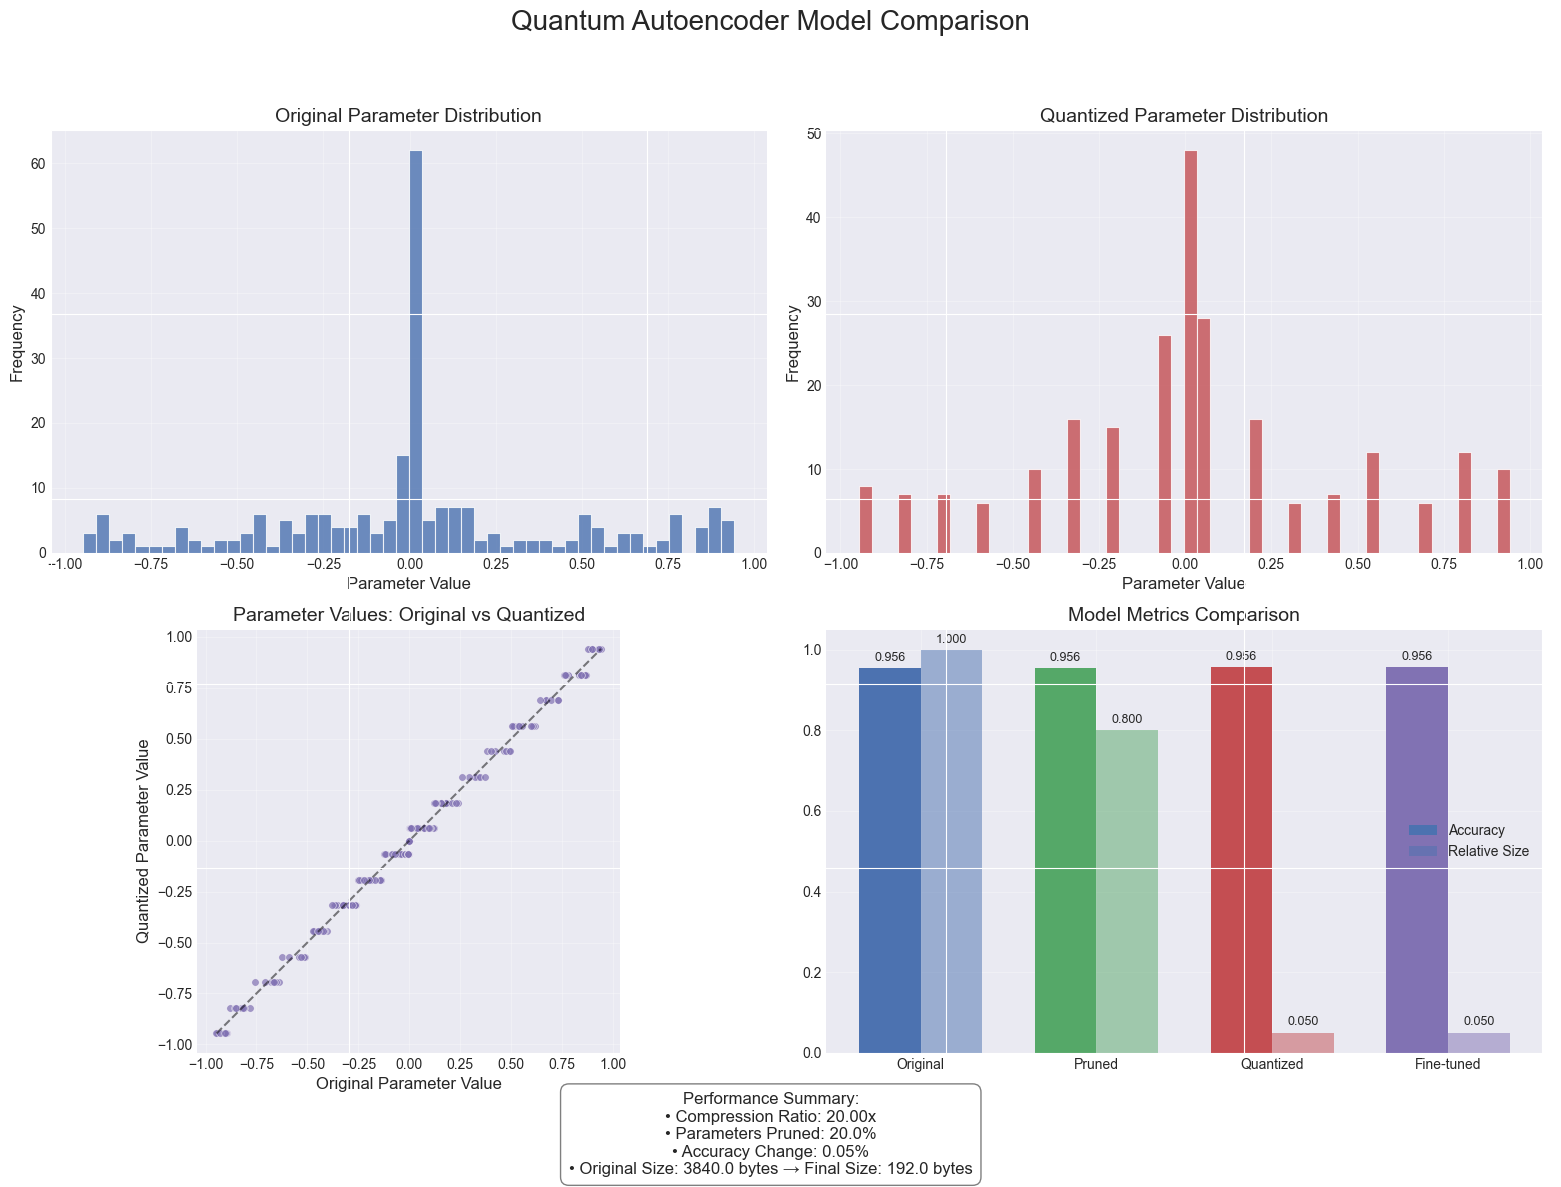

In [14]:
import pennylane as qml
import numpy as np
import torch
import random
from torch.optim import Adam
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import matplotlib.pyplot as plt

def set_seeds(seed=42):
    """Set seeds for reproducibility"""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

class QuantumAutoencoder:
    def __init__(self, n_qubits, latent_qubits, depth=4, params=None):
        self.n_qubits = n_qubits
        self.latent_qubits = latent_qubits
        self.depth = depth
        self.dev = qml.device("default.qubit", wires=n_qubits)
        
        self.n_params = self._calculate_params()
        if params is not None:
            self.params = params
        else:
            self.params = self._initialize_parameters()
        
        self.encoder = qml.QNode(self._encoder_circuit, self.dev, interface="torch")
        self.decoder = qml.QNode(self._decoder_circuit, self.dev, interface="torch")
        
        # Pruning mask (1 = keep, 0 = prune)
        self.pruning_mask = np.ones_like(self.params)
    
    def _calculate_params(self):
        """Calculate total number of parameters"""
        params_per_qubit = 6
        params_per_layer = self.n_qubits * params_per_qubit
        total_layers = 2 * self.depth
        return params_per_layer * total_layers
    
    def _initialize_parameters(self):
        """Improved parameter initialization"""
        params = np.zeros(self.n_params)
        # Xavier/Glorot initialization scaled to [0, 2π]
        scale = np.sqrt(2.0 / (self.n_qubits + self.latent_qubits)) * np.pi
        for i in range(self.n_params):
            params[i] = np.random.uniform(-scale, scale)
        return params

    def _encoder_circuit(self, data, params):
        """Enhanced encoder circuit with proper padding for 78 features"""
        # AmplitudeEmbedding handles the padding to 2^7 = 128 dimensions
        qml.AmplitudeEmbedding(data, wires=range(self.n_qubits), normalize=True, pad_with=0.0)
        
        param_idx = 0
        for d in range(self.depth):
            # More rotations per qubit
            for i in range(self.n_qubits):
                qml.Rot(params[param_idx], params[param_idx + 1], 
                       params[param_idx + 2], wires=i)
                qml.RX(params[param_idx + 3], wires=i)
                qml.RY(params[param_idx + 4], wires=i)
                qml.RZ(params[param_idx + 5], wires=i)
                param_idx += 6
            
            # Enhanced entanglement pattern
            for i in range(self.n_qubits - 1):
                qml.CRZ(params[param_idx % self.n_params], wires=[i, i + 1])
                qml.CNOT(wires=[i, i + 1])
            
            if self.n_qubits > 2:
                for i in range(0, self.n_qubits - 2, 2):
                    qml.CRX(params[(param_idx + 1) % self.n_params], wires=[i, i + 2])
                    qml.CNOT(wires=[i, i + 2])
        
        return qml.state()
    
    def _decoder_circuit(self, latent_state, params):
        """Enhanced decoder circuit"""
        qml.QubitStateVector(latent_state, wires=range(self.latent_qubits))
            
        # Better initialization of non-latent qubits
        for i in range(self.latent_qubits, self.n_qubits):
            qml.Hadamard(wires=i)
            qml.RY(np.pi/4, wires=i)
            qml.RZ(np.pi/4, wires=i)
            
        param_idx = self.n_params // 2
        for d in range(self.depth):
            for i in range(self.n_qubits):
                qml.Rot(params[param_idx], params[param_idx + 1], 
                       params[param_idx + 2], wires=i)
                qml.RX(params[param_idx + 3], wires=i)
                qml.RY(params[param_idx + 4], wires=i)
                qml.RZ(params[param_idx + 5], wires=i)
                param_idx += 6
                
            for i in range(self.n_qubits - 1):
                qml.CRZ(params[param_idx % self.n_params], wires=[i, i + 1])
                qml.CNOT(wires=[i, i + 1])
                
            if self.n_qubits > 2:
                for i in range(0, self.n_qubits - 2, 2):
                    qml.CRX(params[(param_idx + 1) % self.n_params], wires=[i, i + 2])
                    qml.CNOT(wires=[i, i + 2])
            
        return qml.state()
        
    def get_latent_state(self, encoded_state):
        """Improved latent state extraction with proper Hermitian handling"""
        if torch.is_tensor(encoded_state):
            encoded_state = encoded_state.detach().numpy()
        
        # Ensure we're working with complex numbers
        encoded_state = encoded_state.astype(complex)
        
        # Create density matrix
        state_matrix = np.outer(encoded_state, np.conjugate(encoded_state))
        
        # Extract reduced density matrix for latent space
        dim = 2**self.latent_qubits
        reduced_matrix = state_matrix[:dim, :dim]
        
        # Ensure matrix is Hermitian before eigendecomposition
        reduced_matrix = (reduced_matrix + reduced_matrix.conj().T) / 2
        
        # Perform eigendecomposition
        eigenvals, eigenvecs = np.linalg.eigh(reduced_matrix)
        
        # Use top eigenvectors with proper normalization
        top_k = 2
        top_indices = np.argsort(eigenvals)[-top_k:]
        weights = eigenvals[top_indices]
        # Normalize weights to sum to 1
        weights = weights / np.sum(weights)
        
        # Combine eigenvectors
        latent_state = np.zeros(dim, dtype=complex)
        for w, i in zip(weights, top_indices):
            latent_state += np.sqrt(w) * eigenvecs[:, i]
            
        # Ensure proper normalization
        latent_state = latent_state / np.linalg.norm(latent_state)
        return latent_state
        
    def forward(self, x):
        """Forward pass with proper tensor type handling"""
        # Convert input to numpy array if it's a tensor
        if torch.is_tensor(x):
            x_np = x.detach().numpy()
        else:
            x_np = x
            
        # Process through encoder
        encoded = self.encoder(x_np, self.params)
        
        # Get latent representation
        latent = self.get_latent_state(encoded)
        
        # Process through decoder
        decoded = self.decoder(latent, self.params)
        
        # Return result in the same format as the input
        if torch.is_tensor(x):
            # Convert to PyTorch tensor preserving gradients
            if isinstance(decoded, np.ndarray):
                decoded_tensor = torch.tensor(decoded, dtype=torch.complex128)
            else:
                decoded_tensor = decoded
            return decoded_tensor
        else:
            return decoded
    
    def apply_pruning(self, threshold_percentile=20):
        """
        Prune parameters with absolute values below a threshold percentile
        Returns the percentage of parameters pruned
        """
        abs_params = np.abs(self.params)
        threshold = np.percentile(abs_params, threshold_percentile)
        self.pruning_mask = np.where(abs_params > threshold, 1, 0)
        pruned_count = np.sum(self.pruning_mask == 0)
        return (pruned_count / len(self.params)) * 100
    
    def apply_quantization(self, bits=4):
        """
        Quantize parameters to specified bit precision
        Returns the original and quantized parameters for comparison
        """
        original_params = self.params.copy()
        
        # Find min and max for scaling
        p_min, p_max = np.min(self.params), np.max(self.params)
        
        # Scale to [0, 2^bits - 1]
        scale = (2**bits - 1) / (p_max - p_min)
        
        # Quantize
        quantized_int = np.round((self.params - p_min) * scale)
        
        # Scale back to original range
        self.params = (quantized_int / scale) + p_min
        
        # Apply pruning mask to ensure quantized pruned values stay at zero
        self.params = self.params * self.pruning_mask
        
        return original_params, self.params

def preprocess_data(X):
    """Enhanced data preprocessing specifically for 78 features mapped to 7 qubits (128 dimensions)"""
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Normalize each sample to have unit norm
    X_normalized = X_scaled / np.sqrt(np.sum(X_scaled**2, axis=1))[:, np.newaxis]
    
    # For amplitude encoding with 7 qubits (128 dimensions), padding will be handled by PennyLane
    # but we need to ensure our data is properly prepared
    return X_normalized

def evaluate_model(model, X_test):
    """Evaluate model on test data and return accuracy"""
    losses = []
    with torch.no_grad():
        for x in X_test:
            decoded = model.forward(x)
            decoded = np.real(decoded) if not torch.is_tensor(decoded) else decoded.real.numpy()
            loss = np.mean((decoded[:len(x)] - x)**2)
            losses.append(loss)
    
    test_loss = np.mean(losses)
    test_accuracy = 1 / (1 + test_loss)
    return test_loss, test_accuracy

def train_model(X, n_epochs=100, batch_size=4, learning_rate=0.002, seed=42):
    """Enhanced training process for quantum autoencoder"""
    set_seeds(seed)
    
    # Use the provided X dataset
    # Split data into train, validation, and test sets
    X_train, X_temp = train_test_split(X, test_size=0.3, random_state=seed)
    X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=seed)  # 15%/15% val/test split
    
    # Preprocess each dataset
    X_train = preprocess_data(X_train)
    X_val = preprocess_data(X_val)
    X_test = preprocess_data(X_test)
    
    # Number of Qubits
    n_qubits = 5
    latent_qubits = 3  # Reduced dimensionality
    
    model = QuantumAutoencoder(n_qubits=n_qubits, latent_qubits=latent_qubits)
    
    params = torch.tensor(model.params, requires_grad=True)
    optimizer = Adam([params], lr=learning_rate)
    
    best_accuracy = 0.0
    best_params = None
    patience = 10
    patience_counter = 0
    
    metrics = {'train_losses': [], 'train_accuracies': [], 
              'val_losses': [], 'val_accuracies': [], 'test_losses':[], 'test_accuracies': []}
    
    print("\nTraining Progress:")
    print("Epoch | Train Loss | Train Acc | Val Loss | Val Acc | Test Loss | Test Acc")
    print("-" * 75)
    
    for epoch in range(n_epochs):
        model.params = params.detach().numpy()
        epoch_loss = 0
        n_batches = max(1, len(X_train) // batch_size)
        
        for _ in range(n_batches):
            optimizer.zero_grad()
            batch_idx = np.random.choice(len(X_train), min(batch_size, len(X_train)))
            batch_data = X_train[batch_idx]
            
            # Initialize batch loss properly for accumulation
            batch_loss = 0.0
            
            for x in batch_data:
                # Convert input to tensor
                x_tensor = torch.tensor(x, dtype=torch.float64)
                
                # Forward pass
                decoded = model.forward(x)
                
                # Ensure decoded is a tensor with proper type
                if not torch.is_tensor(decoded):
                    decoded = torch.tensor(np.real(decoded), dtype=torch.float64, requires_grad=True)
                elif decoded.dtype != torch.float64:
                    decoded = decoded.real.to(torch.float64)
                
                # Calculate individual sample loss
                # Only compare against original dimensions
                reconstruction_loss = torch.mean((decoded[:len(x_tensor)] - x_tensor)**2)
                
                # Accumulate loss (without requiring grad)
                batch_loss += reconstruction_loss.item()
            
            # Calculate average reconstruction loss for the batch
            avg_recon_loss = batch_loss / len(batch_data)
            
            # Add L2 regularization directly to the final loss calculation
            final_loss = torch.tensor(avg_recon_loss, requires_grad=True) + 0.001 * torch.sum(params**2)
            
            # Backward pass on the properly constructed loss
            final_loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_([params], max_norm=1.0)
            
            # Optimizer step
            optimizer.step()
            
            # Record loss for this batch
            epoch_loss += final_loss.item()
        
        train_loss = epoch_loss / n_batches
        train_accuracy = 1 / (1 + train_loss)
        
        # Validation
        val_losses = []
        with torch.no_grad():
            for x in X_val:
                decoded = model.forward(x)
                decoded = np.real(decoded) if not torch.is_tensor(decoded) else decoded.real.numpy()
                val_loss = np.mean((decoded[:len(x)] - x)**2)
                val_losses.append(val_loss)
        
        # Evaluate on test set
        test_losses = []
        with torch.no_grad():
            for x in X_test:
                decoded = model.forward(x)
                decoded = np.real(decoded) if not torch.is_tensor(decoded) else decoded.real.numpy()
                test_loss = np.mean((decoded[:len(x)] - x)**2)
                test_losses.append(test_loss)

        test_loss = np.mean(test_losses)
        test_accuracy = 1 / (1 + test_loss)
        val_loss = np.mean(val_losses)
        val_accuracy = 1 / (1 + val_loss)

        metrics['test_losses'].append(test_loss)
        metrics['test_accuracies'].append(test_accuracy)
        metrics['train_losses'].append(train_loss)
        metrics['train_accuracies'].append(train_accuracy)
        metrics['val_losses'].append(val_loss)
        metrics['val_accuracies'].append(val_accuracy)
        
        print(f"{epoch:5d} | {train_loss:.4f} | {train_accuracy:.4f} | {val_loss:.4f} | {val_accuracy:.4f} | {test_loss:.4f} | {test_accuracy:.4f}")
        
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params = params.detach().clone()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("\nEarly stopping triggered!")
            break
        
        if val_accuracy >= 0.998 and train_accuracy >= 0.998:
            print("\nTarget accuracy achieved!")
            break
    
    model.params = best_params.numpy()
    return model, best_accuracy, metrics, X_test

def compare_models(X, seed=42):
    """Train and compare original, pruned, and quantized models"""
    set_seeds(seed)
    
    
    # Train original model
    print("Training original model...")
    original_model, _, _, X_test = train_model(X, n_epochs=50, seed=seed)
    
    # Evaluate original model
    print("\nEvaluating original model...")
    original_loss, original_accuracy = evaluate_model(original_model, X_test)
    
    # Create pruned model (clone from original)
    print("\nApplying pruning...")
    pruned_model = QuantumAutoencoder(
        n_qubits=original_model.n_qubits,
        latent_qubits=original_model.latent_qubits,
        depth=original_model.depth,
        params=original_model.params.copy()
    )
    
    # Apply pruning (prune 20% of smallest magnitude parameters)
    pruning_percentage = pruned_model.apply_pruning(threshold_percentile=20)
    print(f"Pruned {pruning_percentage:.2f}% of parameters")
    
    # Evaluate pruned model
    pruned_loss, pruned_accuracy = evaluate_model(pruned_model, X_test)
    
    # Create quantized model (clone from pruned)
    print("\nApplying quantization...")
    quantized_model = QuantumAutoencoder(
        n_qubits=pruned_model.n_qubits,
        latent_qubits=pruned_model.latent_qubits,
        depth=pruned_model.depth,
        params=pruned_model.params.copy()
    )
    quantized_model.pruning_mask = pruned_model.pruning_mask.copy()
    
    # Apply 4-bit quantization
    original_params, quantized_params = quantized_model.apply_quantization(bits=4)
    
    # Evaluate quantized model
    quantized_loss, quantized_accuracy = evaluate_model(quantized_model, X_test)
    
    # Fine-tune quantized model
    print("\nFine-tuning quantized model...")
    # Convert params to tensor for fine-tuning
    params = torch.tensor(quantized_model.params, requires_grad=True)
    optimizer = Adam([params], lr=0.0005)  # Lower learning rate for fine-tuning
    
    # Preprocess data
    X_train, _ = train_test_split(X, test_size=0.3, random_state=seed)
    X_train = preprocess_data(X_train)
    
    # Fine-tuning loop (shorter)
    for epoch in range(20):
        # Apply params to model
        quantized_model.params = params.detach().numpy()
        
        # Batch processing
        batch_idx = np.random.choice(len(X_train), min(8, len(X_train)))
        batch_data = X_train[batch_idx]
        
        # Process batch
        optimizer.zero_grad()
        
        # Track loss as a tensor with gradients
        batch_loss = torch.tensor(0.0, dtype=torch.float64, requires_grad=True)
        
        for i, x in enumerate(batch_data):
            x_tensor = torch.tensor(x, dtype=torch.float64)
            
            # Set model parameters for this forward pass
            quantized_model.params = params.detach().numpy()
            
            # Forward pass
            decoded = quantized_model.forward(x)
            
            # Ensure decoded is a tensor with proper type
            if not torch.is_tensor(decoded):
                decoded = torch.tensor(np.real(decoded), dtype=torch.float64)
            elif decoded.dtype != torch.float64:
                decoded = decoded.real.to(torch.float64)
            
            # Calculate MSE loss with gradients attached
            if i == 0:
                # For the first sample, create a loss tensor with gradients
                batch_loss = torch.mean((decoded[:len(x_tensor)] - x_tensor)**2)
            else:
                # For subsequent samples, accumulate loss
                batch_loss = batch_loss + torch.mean((decoded[:len(x_tensor)] - x_tensor)**2)
        
        # Calculate average loss
        avg_loss = batch_loss / len(batch_data)
        
        # Add L2 regularization
        final_loss = avg_loss + 0.001 * torch.sum(params**2)
        
        # Backward and optimize
        final_loss.backward()
        optimizer.step()
        
        # Re-quantize after gradient update
        quantized_model.params = params.detach().numpy()
        _, quantized_model.params = quantized_model.apply_quantization(bits=4)
        params.data = torch.tensor(quantized_model.params)
        
        # Keep pruned parameters at zero
        quantized_model.params = quantized_model.params * quantized_model.pruning_mask
        params.data = torch.tensor(quantized_model.params)
        
        if (epoch + 1) % 5 == 0:
            try:
                print(f"Fine-tuning epoch {epoch+1}, Loss: {final_loss.item():.6f}")
            except:
                print(f"Fine-tuning epoch {epoch+1}, Loss calculation failed but training continues")
    
    # Final evaluation of fine-tuned quantized model
    finetuned_loss, finetuned_accuracy = evaluate_model(quantized_model, X_test)
    
    # Calculate compression metrics
    param_count = len(original_model.params)
    original_size = param_count * 64  # 64-bit floating point (8 bytes)
    pruned_size = np.sum(pruned_model.pruning_mask) * 64  # Only non-pruned params
    quantized_size = np.sum(quantized_model.pruning_mask) * 4  # 8-bit quantized non-pruned params
    compression_ratio = original_size / quantized_size
    
    # Print results
    print("\n" + "="*50)
    print("MODEL COMPARISON RESULTS")
    print("="*50)
    print(f"Original Model Accuracy:       {original_accuracy:.6f}")
    print(f"Pruned Model Accuracy:         {pruned_accuracy:.6f}")
    print(f"Quantized Model Accuracy:      {quantized_accuracy:.6f}")
    print(f"Fine-tuned Quantized Accuracy: {finetuned_accuracy:.6f}")
    print("-"*50)
    print(f"Original Size:        {original_size/4:.1f} bytes (100.0%)")
    print(f"After Pruning:        {pruned_size/4:.1f} bytes ({pruned_size/original_size*100:.1f}%)")
    print(f"After Quantization:   {quantized_size/4:.1f} bytes ({quantized_size/original_size*100:.1f}%)")
    print(f"Compression Ratio:    {compression_ratio:.2f}x")
    print(f"Accuracy Change:      {(finetuned_accuracy-original_accuracy)/original_accuracy*100:.2f}%")
    
    # Create enhanced visualizations with better styling
    plt.style.use('seaborn-v0_8-darkgrid')
    
    # Define a consistent color palette
    colors = {
        'original': '#4C72B0',      # Blue
        'pruned': '#55A868',        # Green
        'quantized': '#C44E52',     # Red
        'finetuned': '#8172B3'      # Purple
    }
    
    fig = plt.figure(figsize=(16, 12))
    fig.suptitle('Quantum Autoencoder Model Comparison', fontsize=20, y=0.98)
    
    # Original parameters histogram
    ax1 = plt.subplot(2, 2, 1)
    n, bins, patches = ax1.hist(original_params.flatten(), bins=50, alpha=0.8, 
                               color=colors['original'], edgecolor='white', linewidth=0.8)
    ax1.set_title("Original Parameter Distribution", fontsize=14)
    ax1.set_xlabel("Parameter Value", fontsize=12)
    ax1.set_ylabel("Frequency", fontsize=12)
    ax1.grid(alpha=0.3)
    
    # Quantized parameters histogram
    ax2 = plt.subplot(2, 2, 2)
    n, bins, patches = ax2.hist(quantized_params.flatten(), bins=50, alpha=0.8,
                               color=colors['quantized'], edgecolor='white', linewidth=0.8)
    ax2.set_title("Quantized Parameter Distribution", fontsize=14)
    ax2.set_xlabel("Parameter Value", fontsize=12)
    ax2.set_ylabel("Frequency", fontsize=12)
    ax2.grid(alpha=0.3)
    
    # Highlight parameter changes with scatter plot
    ax3 = plt.subplot(2, 2, 3)
    
    # Only plot a subset of parameters (up to 1000 for visibility)
    max_params = min(1000, len(original_params))
    sample_indices = np.random.choice(len(original_params), max_params, replace=False)
    
    ax3.scatter(original_params.flatten()[sample_indices], 
                quantized_params.flatten()[sample_indices], 
                alpha=0.7, s=30, color=colors['finetuned'], edgecolor='white', linewidth=0.5)
    
    # Add diagonal line for reference
    min_val = min(original_params.min(), quantized_params.min())
    max_val = max(original_params.max(), quantized_params.max())
    ax3.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
    
    ax3.set_title("Parameter Values: Original vs Quantized", fontsize=14)
    ax3.set_xlabel("Original Parameter Value", fontsize=12)
    ax3.set_ylabel("Quantized Parameter Value", fontsize=12)
    ax3.grid(alpha=0.3)
    ax3.set_aspect('equal')
    
    # Accuracy and size comparison as a grouped bar chart
    ax4 = plt.subplot(2, 2, 4)
    
    # Group bar data
    x = np.arange(4)  # four groups
    width = 0.35
    
    # First set of bars: Accuracy
    metrics = ["Original", "Pruned", "Quantized", "Fine-tuned"]
    accuracies = [original_accuracy, pruned_accuracy, quantized_accuracy, finetuned_accuracy]
    bars1 = ax4.bar(x - width/2, accuracies, width, label='Accuracy',
                   color=[colors['original'], colors['pruned'], colors['quantized'], colors['finetuned']])
    
    # Second set of bars: Relative Size (normalized)
    sizes = [1.0, pruned_size/original_size, quantized_size/original_size, quantized_size/original_size]  # Normalized to original
    bars2 = ax4.bar(x + width/2, sizes, width, label='Relative Size',
                   color=[colors['original'], colors['pruned'], colors['quantized'], colors['finetuned']], 
                   alpha=0.5)
    
    # Add labels and styling
    ax4.set_title("Model Metrics Comparison", fontsize=14)
    ax4.set_xticks(x)
    ax4.set_xticklabels(metrics)
    ax4.legend()
    ax4.grid(alpha=0.3)
    
    # Add exact values on bars
    def autolabel(bars):
        for bar in bars:
            height = bar.get_height()
            ax4.annotate(f'{height:.3f}',
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3),
                         textcoords="offset points",
                         ha='center', va='bottom', fontsize=9)
    
    autolabel(bars1)
    autolabel(bars2)
    
    # Create a fifth subplot for additional metrics
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    
    # Add text summary of key metrics
    summary_text = (
        f"Performance Summary:\n"
        f"• Compression Ratio: {compression_ratio:.2f}x\n"
        f"• Parameters Pruned: {pruning_percentage:.1f}%\n"
        f"• Accuracy Change: {(finetuned_accuracy-original_accuracy)/original_accuracy*100:.2f}%\n"
        f"• Original Size: {original_size/4:.1f} bytes → Final Size: {quantized_size/4:.1f} bytes"
    )
    
    plt.figtext(0.5, 0.01, summary_text, ha="center", fontsize=12, 
                bbox={"facecolor":"white", "alpha":0.5, "pad":5, "boxstyle":"round,pad=0.5"})
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.savefig("quantum_model_comparison.png", dpi=300, bbox_inches='tight')
    
    # Plot training history if metrics are available
    try:
        if isinstance(metrics, dict) and 'train_losses' in metrics:
            fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
            fig2.suptitle('Quantum Autoencoder Training History', fontsize=18)
            
            epochs = range(len(metrics['train_losses']))
            
            # Plot losses
            ax1.plot(epochs, metrics['train_losses'], label='Train', color=colors['original'], linewidth=2)
            ax1.plot(epochs, metrics['val_losses'], label='Validation', color=colors['pruned'], linewidth=2)
            ax1.plot(epochs, metrics['test_losses'], label='Test', color=colors['quantized'], linewidth=2, linestyle='--')
            ax1.set_title('Loss During Training', fontsize=14)
            ax1.set_xlabel('Epochs', fontsize=12)
            ax1.set_ylabel('Loss', fontsize=12)
            ax1.legend()
            ax1.grid(alpha=0.3)
            
            # Plot accuracy
            ax2.plot(epochs, metrics['train_accuracies'], label='Train', color=colors['original'], linewidth=2)
            ax2.plot(epochs, metrics['val_accuracies'], label='Validation', color=colors['pruned'], linewidth=2)
            ax2.plot(epochs, metrics['test_accuracies'], label='Test', color=colors['quantized'], linewidth=2, linestyle='--')
            ax2.set_title('Accuracy During Training', fontsize=14)
            ax2.set_xlabel('Epochs', fontsize=12)
            ax2.set_ylabel('Accuracy', fontsize=12)
            ax2.legend()
            ax2.grid(alpha=0.3)
            
            plt.tight_layout()
            plt.savefig("quantum_training_history.png", dpi=300, bbox_inches='tight')
    except Exception as e:
        print(f"Could not plot training history: {e}")
    
    return {
        "original_accuracy": original_accuracy,
        "pruned_accuracy": pruned_accuracy, 
        "quantized_accuracy": quantized_accuracy,
        "finetuned_accuracy": finetuned_accuracy,
        "compression_ratio": compression_ratio,
        "pruning_percentage": pruning_percentage
    }



if __name__ == "__main__":
 
    results = compare_models(X)
    
    # Print summary
    print("\nSUMMARY:")
    print(f"Original model accuracy: {results['original_accuracy']:.6f}")
    print(f"Final model accuracy: {results['finetuned_accuracy']:.6f}")
    print(f"Compression ratio: {results['compression_ratio']:.2f}x")
    print(f"Accuracy impact: {(results['finetuned_accuracy']-results['original_accuracy'])/results['original_accuracy']*100:.2f}%")

In [ ]:
import pennylane as qml
import numpy as np
import torch
import random
from torch.optim import Adam
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import matplotlib.pyplot as plt

def set_seeds(seed=42):
    """Set seeds for reproducibility"""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

class QuantumAutoencoder:
    def __init__(self, n_qubits, latent_qubits, depth=4, params=None):
        self.n_qubits = n_qubits
        self.latent_qubits = latent_qubits
        self.depth = depth
        self.dev = qml.device("default.qubit", wires=n_qubits)
        
        self.n_params = self._calculate_params()
        if params is not None:
            self.params = params
        else:
            self.params = self._initialize_parameters()
        
        self.encoder = qml.QNode(self._encoder_circuit, self.dev, interface="torch")
        self.decoder = qml.QNode(self._decoder_circuit, self.dev, interface="torch")
        
        # Pruning mask (1 = keep, 0 = prune)
        self.pruning_mask = np.ones_like(self.params)
        
        # Quantization info (for tracking and storing quantization state)
        self.quant_info = {
            'enabled': False,
            'bits': 4,
            'symmetric': True,
            'min_val': None,
            'max_val': None,
            'scale': None,
            'zero_point': None,
            'levels': None,
            'quantized_values': None
        }
    
    def _calculate_params(self):
        """Calculate total number of parameters"""
        params_per_qubit = 6
        params_per_layer = self.n_qubits * params_per_qubit
        total_layers = 2 * self.depth
        return params_per_layer * total_layers
    
    def _initialize_parameters(self):
        """Improved parameter initialization"""
        params = np.zeros(self.n_params)
        # Xavier/Glorot initialization scaled to [0, 2π]
        scale = np.sqrt(2.0 / (self.n_qubits + self.latent_qubits)) * np.pi
        for i in range(self.n_params):
            params[i] = np.random.uniform(-scale, scale)
        return params

    def _encoder_circuit(self, data, params):
        """Enhanced encoder circuit with proper padding for 78 features"""
        # AmplitudeEmbedding handles the padding to 2^7 = 128 dimensions
        qml.AmplitudeEmbedding(data, wires=range(self.n_qubits), normalize=True, pad_with=0.0)
        
        param_idx = 0
        for d in range(self.depth):
            # More rotations per qubit
            for i in range(self.n_qubits):
                qml.Rot(params[param_idx], params[param_idx + 1], 
                       params[param_idx + 2], wires=i)
                qml.RX(params[param_idx + 3], wires=i)
                qml.RY(params[param_idx + 4], wires=i)
                qml.RZ(params[param_idx + 5], wires=i)
                param_idx += 6
            
            # Enhanced entanglement pattern
            for i in range(self.n_qubits - 1):
                qml.CRZ(params[param_idx % self.n_params], wires=[i, i + 1])
                qml.CNOT(wires=[i, i + 1])
            
            if self.n_qubits > 2:
                for i in range(0, self.n_qubits - 2, 2):
                    qml.CRX(params[(param_idx + 1) % self.n_params], wires=[i, i + 2])
                    qml.CNOT(wires=[i, i + 2])
        
        return qml.state()
    
    def _decoder_circuit(self, latent_state, params):
        """Enhanced decoder circuit"""
        qml.QubitStateVector(latent_state, wires=range(self.latent_qubits))
            
        # Better initialization of non-latent qubits
        for i in range(self.latent_qubits, self.n_qubits):
            qml.Hadamard(wires=i)
            qml.RY(np.pi/4, wires=i)
            qml.RZ(np.pi/4, wires=i)
            
        param_idx = self.n_params // 2
        for d in range(self.depth):
            for i in range(self.n_qubits):
                qml.Rot(params[param_idx], params[param_idx + 1], 
                       params[param_idx + 2], wires=i)
                qml.RX(params[param_idx + 3], wires=i)
                qml.RY(params[param_idx + 4], wires=i)
                qml.RZ(params[param_idx + 5], wires=i)
                param_idx += 6
                
            for i in range(self.n_qubits - 1):
                qml.CRZ(params[param_idx % self.n_params], wires=[i, i + 1])
                qml.CNOT(wires=[i, i + 1])
                
            if self.n_qubits > 2:
                for i in range(0, self.n_qubits - 2, 2):
                    qml.CRX(params[(param_idx + 1) % self.n_params], wires=[i, i + 2])
                    qml.CNOT(wires=[i, i + 2])
            
        return qml.state()
        
    def get_latent_state(self, encoded_state):
        """Improved latent state extraction with proper Hermitian handling"""
        if torch.is_tensor(encoded_state):
            encoded_state = encoded_state.detach().numpy()
        
        # Ensure we're working with complex numbers
        encoded_state = encoded_state.astype(complex)
        
        # Create density matrix
        state_matrix = np.outer(encoded_state, np.conjugate(encoded_state))
        
        # Extract reduced density matrix for latent space
        dim = 2**self.latent_qubits
        reduced_matrix = state_matrix[:dim, :dim]
        
        # Ensure matrix is Hermitian before eigendecomposition
        reduced_matrix = (reduced_matrix + reduced_matrix.conj().T) / 2
        
        # Perform eigendecomposition
        eigenvals, eigenvecs = np.linalg.eigh(reduced_matrix)
        
        # Use top eigenvectors with proper normalization
        top_k = 2
        top_indices = np.argsort(eigenvals)[-top_k:]
        weights = eigenvals[top_indices]
        # Normalize weights to sum to 1
        weights = weights / np.sum(weights)
        
        # Combine eigenvectors
        latent_state = np.zeros(dim, dtype=complex)
        for w, i in zip(weights, top_indices):
            latent_state += np.sqrt(w) * eigenvecs[:, i]
            
        # Ensure proper normalization
        latent_state = latent_state / np.linalg.norm(latent_state)
        return latent_state
        
    def forward(self, x):
        """Forward pass with proper tensor type handling"""
        # Convert input to numpy array if it's a tensor
        if torch.is_tensor(x):
            x_np = x.detach().numpy()
        else:
            x_np = x
            
        # Process through encoder
        encoded = self.encoder(x_np, self.params)
        
        # Get latent representation
        latent = self.get_latent_state(encoded)
        
        # Process through decoder
        decoded = self.decoder(latent, self.params)
        
        # Return result in the same format as the input
        if torch.is_tensor(x):
            # Convert to PyTorch tensor preserving gradients
            if isinstance(decoded, np.ndarray):
                decoded_tensor = torch.tensor(decoded, dtype=torch.complex128)
            else:
                decoded_tensor = decoded
            return decoded_tensor
        else:
            return decoded
    
    def apply_pruning(self, threshold_percentile=20):
        """
        Prune parameters with absolute values below a threshold percentile
        Returns the percentage of parameters pruned
        """
        abs_params = np.abs(self.params)
        threshold = np.percentile(abs_params, threshold_percentile)
        self.pruning_mask = np.where(abs_params > threshold, 1, 0)
        pruned_count = np.sum(self.pruning_mask == 0)
        return (pruned_count / len(self.params)) * 100
    
    def prepare_4bit_quantization(self, symmetric=True):
        """
        Prepare for 4-bit quantization by calculating quantization parameters
        
        Args:
            symmetric: If True, use symmetric quantization centered around 0
                      If False, use asymmetric quantization
        """
        bits = 4  # Fixed at 4 bits for this improved implementation
        
        # Get the active (non-pruned) parameters
        active_params = self.params[self.pruning_mask == 1]
        
        if len(active_params) == 0:
            print("Warning: No active parameters to quantize")
            return
        
        # Determine min and max values for the quantization range
        min_val = np.min(active_params)
        max_val = np.max(active_params)
        
        # For symmetric quantization, ensure the range is symmetric around zero
        if symmetric:
            # Use the maximum absolute value to set symmetric bounds
            abs_max = max(abs(min_val), abs(max_val))
            min_val = -abs_max
            max_val = abs_max
            
            # For symmetric, zero point is in the middle of the range
            zero_point = (2**bits - 1) // 2
            scale = (max_val - min_val) / (2**bits - 1)
            
            # Create evenly spaced quantization levels (including zero)
            levels = np.arange(2**bits) - zero_point
            quantized_values = levels * scale
        else:
            # For asymmetric quantization
            scale = (max_val - min_val) / (2**bits - 1)
            zero_point = 0  # Asymmetric starts at 0
            
            # Create evenly spaced quantization levels
            levels = np.arange(2**bits)
            quantized_values = min_val + levels * scale
        
        # Store quantization parameters
        self.quant_info = {
            'enabled': True,
            'bits': bits,
            'symmetric': symmetric,
            'min_val': min_val,
            'max_val': max_val,
            'scale': scale,
            'zero_point': zero_point,
            'levels': levels,
            'quantized_values': quantized_values
        }
        
        return self.quant_info
    
    def apply_4bit_quantization(self):
        """
        Apply 4-bit quantization to the parameters based on the prepared quantization info
        Returns original and quantized parameters for comparison
        """
        # Save original parameters
        original_params = self.params.copy()
        
        # Check if quantization has been prepared
        if not self.quant_info['enabled']:
            self.prepare_4bit_quantization()
        
        # Get quantization parameters
        bits = self.quant_info['bits']
        min_val = self.quant_info['min_val']
        max_val = self.quant_info['max_val']
        scale = self.quant_info['scale']
        zero_point = self.quant_info['zero_point']
        quantized_values = self.quant_info['quantized_values']
        symmetric = self.quant_info['symmetric']
        
        # Apply quantization only to non-pruned parameters
        for i in range(len(self.params)):
            if self.pruning_mask[i] == 1:
                # Clamp parameter value to the allowed range
                param_value = max(min(self.params[i], max_val), min_val)
                
                if symmetric:
                    # For symmetric, find the closest level
                    level_idx = round((param_value / scale) + zero_point)
                    # Ensure it's within valid range
                    level_idx = max(0, min(level_idx, 2**bits - 1))
                else:
                    # For asymmetric, calculate the quantized level
                    level_idx = round((param_value - min_val) / scale)
                    # Ensure it's within valid range
                    level_idx = max(0, min(level_idx, 2**bits - 1))
                
                # Set parameter to the quantized value
                self.params[i] = quantized_values[level_idx]
            else:
                # Keep pruned parameters at exactly zero
                self.params[i] = 0.0
        
        return original_params, self.params
    
    def quantize_parameter_update(self, updated_params):
        """
        Quantize parameters after an update (useful during fine-tuning)
        Args:
            updated_params: The updated parameters (numpy array or torch tensor)
        Returns:
            Quantized parameters
        """
        # Convert to numpy if tensor
        if torch.is_tensor(updated_params):
            params_np = updated_params.detach().numpy()
        else:
            params_np = updated_params
            
        # Make sure quantization info is available
        if not self.quant_info['enabled']:
            self.prepare_4bit_quantization()
            
        # Get quantization parameters
        bits = self.quant_info['bits']
        min_val = self.quant_info['min_val']
        max_val = self.quant_info['max_val']
        scale = self.quant_info['scale']
        zero_point = self.quant_info['zero_point']
        quantized_values = self.quant_info['quantized_values']
        symmetric = self.quant_info['symmetric']
        
        # Create a copy for the quantized result
        quantized_params = params_np.copy()
        
        # Apply quantization only to non-pruned parameters
        for i in range(len(params_np)):
            if self.pruning_mask[i] == 1:
                # Clamp parameter value to the allowed range
                param_value = max(min(params_np[i], max_val), min_val)
                
                if symmetric:
                    # For symmetric, find the closest level
                    level_idx = round((param_value / scale) + zero_point)
                    # Ensure it's within valid range
                    level_idx = max(0, min(level_idx, 2**bits - 1))
                else:
                    # For asymmetric, calculate the quantized level
                    level_idx = round((param_value - min_val) / scale)
                    # Ensure it's within valid range
                    level_idx = max(0, min(level_idx, 2**bits - 1))
                
                # Set parameter to the quantized value
                quantized_params[i] = quantized_values[level_idx]
            else:
                # Keep pruned parameters at exactly zero
                quantized_params[i] = 0.0
                
        return quantized_params
    
    def visualize_quantization(self):
        """Visualize the effects of 4-bit quantization on parameters"""
        if not hasattr(self, 'original_params') or self.original_params is None:
            print("Original parameters not available. Run apply_4bit_quantization first.")
            return
            
        # Plot only non-pruned parameters
        mask = self.pruning_mask == 1
        original = self.original_params[mask]
        quantized = self.params[mask]
        
        plt.figure(figsize=(12, 10))
        
        # Create parameter distribution histogram
        plt.subplot(2, 2, 1)
        plt.hist(original, bins=50, alpha=0.5, label='Original')
        plt.hist(quantized, bins=16, alpha=0.5, label='4-bit Quantized')
        plt.xlabel('Parameter Value')
        plt.ylabel('Frequency')
        plt.title('Parameter Distribution')
        plt.legend()
        
        # Scatter plot of original vs quantized
        plt.subplot(2, 2, 2)
        plt.scatter(original, quantized, alpha=0.5)
        plt.xlabel('Original Value')
        plt.ylabel('Quantized Value')
        plt.title('Original vs. Quantized Values')
        
        # Show the quantization levels
        if self.quant_info['enabled']:
            levels = self.quant_info['quantized_values']
            plt.subplot(2, 2, 3)
            plt.stem(levels, np.ones_like(levels), linefmt='r-', markerfmt='ro')
            plt.xlabel('Quantization Level')
            plt.ylabel('Value')
            plt.title('4-bit Quantization Levels')
            
            # Histogram of selected levels
            level_indices = []
            for i in range(len(self.params)):
                if self.pruning_mask[i] == 1:
                    # Find which level this parameter was quantized to
                    level_idx = np.argmin(np.abs(self.params[i] - levels))
                    level_indices.append(level_idx)
                    
            plt.subplot(2, 2, 4)
            plt.hist(level_indices, bins=16, rwidth=0.8)
            plt.xlabel('Quantization Level Index')
            plt.ylabel('Frequency')
            plt.title('Distribution of Used Quantization Levels')
            
        plt.tight_layout()
        plt.savefig('quantization_visualization.png')
        plt.close()

def preprocess_data(X):
    """Enhanced data preprocessing specifically for 78 features mapped to 7 qubits (128 dimensions)"""
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Normalize each sample to have unit norm
    X_normalized = X_scaled / np.sqrt(np.sum(X_scaled**2, axis=1))[:, np.newaxis]
    
    # For amplitude encoding with 7 qubits (128 dimensions), padding will be handled by PennyLane
    # but we need to ensure our data is properly prepared
    return X_normalized

def evaluate_model(model, X_test):
    """Evaluate model on test data and return accuracy"""
    losses = []
    with torch.no_grad():
        for x in X_test:
            decoded = model.forward(x)
            decoded = np.real(decoded) if not torch.is_tensor(decoded) else decoded.real.numpy()
            loss = np.mean((decoded[:len(x)] - x)**2)
            losses.append(loss)
    
    test_loss = np.mean(losses)
    test_accuracy = 1 / (1 + test_loss)
    return test_loss, test_accuracy

def train_model(X, n_epochs=100, batch_size=4, learning_rate=0.002, seed=42):
    """Enhanced training process for quantum autoencoder"""
    set_seeds(seed)
    
    # Use the provided X dataset
    # Split data into train, validation, and test sets
    X_train, X_temp = train_test_split(X, test_size=0.3, random_state=seed)
    X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=seed)  # 15%/15% val/test split
    
    # Preprocess each dataset
    X_train = preprocess_data(X_train)
    X_val = preprocess_data(X_val)
    X_test = preprocess_data(X_test)
    
    # Number of Qubits
    n_qubits = 5
    latent_qubits = 3  # Reduced dimensionality
    
    model = QuantumAutoencoder(n_qubits=n_qubits, latent_qubits=latent_qubits)
    
    params = torch.tensor(model.params, requires_grad=True)
    optimizer = Adam([params], lr=learning_rate)
    
    best_accuracy = 0.0
    best_params = None
    patience = 10
    patience_counter = 0
    
    metrics = {'train_losses': [], 'train_accuracies': [], 
              'val_losses': [], 'val_accuracies': [], 'test_losses':[], 'test_accuracies': []}
    
    print("\nTraining Progress:")
    print("Epoch | Train Loss | Train Acc | Val Loss | Val Acc | Test Loss | Test Acc")
    print("-" * 75)
    
    for epoch in range(n_epochs):
        model.params = params.detach().numpy()
        epoch_loss = 0
        n_batches = max(1, len(X_train) // batch_size)
        
        for _ in range(n_batches):
            optimizer.zero_grad()
            batch_idx = np.random.choice(len(X_train), min(batch_size, len(X_train)))
            batch_data = X_train[batch_idx]
            
            # Initialize batch loss properly for accumulation
            batch_loss = 0.0
            
            for x in batch_data:
                # Convert input to tensor
                x_tensor = torch.tensor(x, dtype=torch.float64)
                
                # Forward pass
                decoded = model.forward(x)
                
                # Ensure decoded is a tensor with proper type
                if not torch.is_tensor(decoded):
                    decoded = torch.tensor(np.real(decoded), dtype=torch.float64, requires_grad=True)
                elif decoded.dtype != torch.float64:
                    decoded = decoded.real.to(torch.float64)
                
                # Calculate individual sample loss
                # Only compare against original dimensions
                reconstruction_loss = torch.mean((decoded[:len(x_tensor)] - x_tensor)**2)
                
                # Accumulate loss (without requiring grad)
                batch_loss += reconstruction_loss.item()
            
            # Calculate average reconstruction loss for the batch
            avg_recon_loss = batch_loss / len(batch_data)
            
            # Add L2 regularization directly to the final loss calculation
            final_loss = torch.tensor(avg_recon_loss, requires_grad=True) + 0.001 * torch.sum(params**2)
            
            # Backward pass on the properly constructed loss
            final_loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_([params], max_norm=1.0)
            
            # Optimizer step
            optimizer.step()
            
            # Record loss for this batch
            epoch_loss += final_loss.item()
        
        train_loss = epoch_loss / n_batches
        train_accuracy = 1 / (1 + train_loss)
        
        # Validation
        val_losses = []
        with torch.no_grad():
            for x in X_val:
                decoded = model.forward(x)
                decoded = np.real(decoded) if not torch.is_tensor(decoded) else decoded.real.numpy()
                val_loss = np.mean((decoded[:len(x)] - x)**2)
                val_losses.append(val_loss)
        
        # Evaluate on test set
        test_losses = []
        with torch.no_grad():
            for x in X_test:
                decoded = model.forward(x)
                decoded = np.real(decoded) if not torch.is_tensor(decoded) else decoded.real.numpy()
                test_loss = np.mean((decoded[:len(x)] - x)**2)
                test_losses.append(test_loss)

        test_loss = np.mean(test_losses)
        test_accuracy = 1 / (1 + test_loss)
        val_loss = np.mean(val_losses)
        val_accuracy = 1 / (1 + val_loss)

        metrics['test_losses'].append(test_loss)
        metrics['test_accuracies'].append(test_accuracy)
        metrics['train_losses'].append(train_loss)
        metrics['train_accuracies'].append(train_accuracy)
        metrics['val_losses'].append(val_loss)
        metrics['val_accuracies'].append(val_accuracy)
        
        print(f"{epoch:5d} | {train_loss:.4f} | {train_accuracy:.4f} | {val_loss:.4f} | {val_accuracy:.4f} | {test_loss:.4f} | {test_accuracy:.4f}")
        
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params = params.detach().clone()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("\nEarly stopping triggered!")
            break
        
        if val_accuracy >= 0.998 and train_accuracy >= 0.998:
            print("\nTarget accuracy achieved!")
            break
    
    model.params = best_params.numpy()
    return model, best_accuracy, metrics, X_test

def compare_models(X, seed=42):
    """Train and compare original, pruned, and quantized models with enhanced 4-bit quantization"""
    set_seeds(seed)
    
    # Train original model
    print("Training original model...")
    original_model, _, _, X_test = train_model(X, n_epochs=50, seed=seed)
    
    # Evaluate original model
    print("\nEvaluating original model...")
    original_loss, original_accuracy = evaluate_model(original_model, X_test)
    
    # Create pruned model (clone from original)
    print("\nApplying pruning...")
    pruned_model = QuantumAutoencoder(
        n_qubits=original_model.n_qubits,
        latent_qubits=original_model.latent_qubits,
        depth=original_model.depth,
        params=original_model.params.copy()
    )
    
    # Apply pruning (prune 20% of smallest magnitude parameters)
    pruning_percentage = pruned_model.apply_pruning(threshold_percentile=20)
    print(f"Pruned {pruning_percentage:.2f}% of parameters")
    
    # Evaluate pruned model
    pruned_loss, pruned_accuracy = evaluate_model(pruned_model, X_test)
    
    # Create quantized model (clone from pruned)
    print("\nPreparing for 4-bit quantization...")
    quantized_model = QuantumAutoencoder(
        n_qubits=pruned_model.n_qubits,
        latent_qubits=pruned_model.latent_qubits,
        depth=pruned_model.depth,
        params=pruned_model.params.copy()
    )
    quantized_model.pruning_mask = pruned_model.pruning_mask.copy()
    
    # Prepare for 4-bit symmetric quantization
    quant_info = quantized_model.prepare_4bit_quantization(symmetric=True)
    print(f"Quantization setup: {len(quant_info['quantized_values'])} levels from {quant_info['min_val']:.4f} to {quant_info['max_val']:.4f}")
    
    # Apply 4-bit quantization
    original_params, quantized_params = quantized_model.apply_4bit_quantization()
    
    # Save the original parameters for visualizations
    quantized_model.original_params = original_params
    
    # Evaluate quantized model
    quantized_loss, quantized_accuracy = evaluate_model(quantized_model, X_test)
    
    # Visualize quantization effects
    quantized_model.visualize_quantization()
    
    # Fine-tune quantized model
    print("\nFine-tuning quantized model...")
    # Convert params to tensor for fine-tuning
    params = torch.tensor(quantized_model.params, requires_grad=True)
    optimizer = Adam([params], lr=0.0005)  # Lower learning rate for fine-tuning
    
    # Preprocess data
    X_train, _ = train_test_split(X, test_size=0.3, random_state=seed)
    X_train = preprocess_data(X_train)
    
    # Fine-tuning loop (shorter)
    for epoch in range(20):
        # Apply params to model
        quantized_model.params = params.detach().numpy()